# Fase 2: Modelado con GRU y MLflow

En esta fase, usaremos el dataset procesado (`dataset_processed_advanced.csv`)
para entrenar un modelo de Red Neuronal Recurrente (GRU).

El objetivo es predecir `quantity_available`.

Usaremos **MLflow** para registrar y gestionar nuestros experimentos.

In [13]:
import pandas as pd
import numpy as np

import mlflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


import matplotlib.pyplot as plt
import seaborn as sns
import math 
import os

# Configuración
sns.set_theme(style="whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print("Todas las librerías para modelado GRU y MLflow han sido importadas.")

Todas las librerías para modelado GRU y MLflow han sido importadas.


## 1. Carga de Datos Procesados

Cargamos el dataset `dataset_processed_advanced.csv`.
Este dataset ya tiene todos nuestros features (lags, medias, etc.).

In [14]:
# Cargar el dataset final de la Fase 2
try:
    df_model = pd.read_csv("C:/Users/samil/Desktop/APRENDIZAJE AUTOMATICO/PRIMER INTERCICLO/Practica-2-Aprendizaje-Automactico/data/dataset_processed_advanced.csv")

    print(f"Dataset cargado exitosamente. Forma: {df_model.shape}")


    cols_a_excluir = ['product_sku']
    if 'region_almacen' in df_model.columns:
        cols_a_excluir.append('region_almacen')

    df_model = df_model.drop(columns=cols_a_excluir, errors='ignore')

    print(f"Columnas no numéricas ('{cols_a_excluir}') eliminadas.")
    print("\n--- df_model.info() (solo numéricas) ---")
    df_model.info()

except FileNotFoundError:
    print("Error: No se encontró el archivo 'dataset_processed_advanced.csv'.")
    df_model = pd.DataFrame() 

Dataset cargado exitosamente. Forma: (7050, 40)
Columnas no numéricas ('['product_sku', 'region_almacen']') eliminadas.

--- df_model.info() (solo numéricas) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   prioridad_proveedor         7050 non-null   int64  
 1   quantity_on_hand            7050 non-null   int64  
 2   quantity_reserved           7050 non-null   int64  
 3   quantity_available          7050 non-null   int64  
 4   minimum_stock_level         7050 non-null   int64  
 5   reorder_point               7050 non-null   int64  
 6   optimal_stock_level         7050 non-null   int64  
 7   reorder_quantity            7050 non-null   int64  
 8   average_daily_usage         7050 non-null   float64
 9   unit_cost                   7050 non-null   float64
 10  total_value                 7050 non-null 

## 2. Escalado de Datos (Normalización)

Las Redes Neuronales (GRU) **requieren** que todos los datos estén
normalizados (usualmente entre 0 y 1).

* `scaler_y`: Escala nuestro target (`quantity_available`).
* `scaler_X`: Escala todos nuestros 38 features.

**Importante:** Guardamos los "scalers" para poder *revertir*
las predicciones al final y entenderlas en unidades reales.

In [15]:
if not df_model.empty:
    # 1. Target
    y = df_model[['quantity_available']]

    # 2. Features
    X = df_model.drop(columns=['quantity_available'])

    # Convertir booleanos a 0/1
    bool_cols = X.select_dtypes(include=['bool']).columns
    X[bool_cols] = X[bool_cols].astype(int)

    # Eliminar columnas no numéricas (strings, fechas, etc.)
    X = X.select_dtypes(include=['number'])

    N_FEATURES = X.shape[1]

    # 3. Scalers
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    scaler_X = MinMaxScaler(feature_range=(0, 1))

    # 4. Transformación
    y_scaled = scaler_y.fit_transform(y)
    X_scaled = scaler_X.fit_transform(X)

    print("Datos escalados a [0, 1].")
    print(f"Forma de X_scaled: {X_scaled.shape}")
    print(f"Forma de y_scaled: {y_scaled.shape}")
    print(f"Número de features: {N_FEATURES}")
else:
    print("Dataset vacío, no se puede escalar.")
    X_scaled, y_scaled, scaler_X, scaler_y, N_FEATURES = [None]*5

Datos escalados a [0, 1].
Forma de X_scaled: (7050, 36)
Forma de y_scaled: (7050, 1)
Número de features: 36


## 3. División Cronológica (Train/Validation/Test)

Para series de tiempo, debemos
dividir los datos cronológicamente:
- **Train (80%):** El pasado más antiguo para aprendizaje
- **Validation (10%):** Datos recientes para ajuste de hiperparámetros
- **Test (10%):** El futuro (examen final, datos nunca vistos)

**¿Por qué esta división?**
- 80% Train: Suficientes datos para que el modelo aprenda patrones complejos
- 10% Validation: Permite evaluar generalización sin comprometer datos de prueba
- 10% Test: Conjunto limpio para evaluación final imparcial

**Importante:** En series temporales, la división debe ser cronológica (no aleatoria)
para respetar la secuencia temporal de los datos.

In [16]:
if X_scaled is not None:
    # Calcular los puntos de corte (80/10/10)
    total_size = len(X_scaled)
    train_size = int(total_size * 0.80)  # 80%
    val_size = int(total_size * 0.10)    # 10%
    # El resto es el test_size (10%)

    # Dividir X cronológicamente
    X_train_raw = X_scaled[0:train_size]
    X_val_raw = X_scaled[train_size : train_size + val_size]
    X_test_raw = X_scaled[train_size + val_size :]

    # Dividir y cronológicamente
    y_train_raw = y_scaled[0:train_size]
    y_val_raw = y_scaled[train_size : train_size + val_size]
    y_test_raw = y_scaled[train_size + val_size :]

    print(f" División cronológica completada:")
    print(f"   Total de datos: {total_size:,}")
    print(f"   Datos de Train: {len(X_train_raw):,} ({len(X_train_raw)/total_size*100:.1f}%)")
    print(f"   Datos de Validation: {len(X_val_raw):,} ({len(X_val_raw)/total_size*100:.1f}%)")
    print(f"   Datos de Test: {len(X_test_raw):,} ({len(X_test_raw)/total_size*100:.1f}%)")
    print(f"\n    Nota: La división respeta el orden cronológico de los datos.")
else:
    print(" Datos no escalados, no se puede dividir.")
    X_train_raw, X_val_raw, X_test_raw, y_train_raw, y_val_raw, y_test_raw = [None] * 6

 División cronológica completada:
   Total de datos: 7,050
   Datos de Train: 5,640 (80.0%)
   Datos de Validation: 705 (10.0%)
   Datos de Test: 705 (10.0%)

    Nota: La división respeta el orden cronológico de los datos.


## 4. Creación de Secuencias

Aquí convertimos nuestras "filas" en "películas" (secuencias).
* `N_STEPS = 7`
* Definimos que 1 "película" = 7 días de historia.
* El modelo mirará los 7 días de `X` para predecir el `y` del día 8.
* El formato de entrada final será: `(muestras, 7, 38)`

In [17]:
N_STEPS = 7 # 7 días de historia para predecir el 8vo

def create_sequences(X_data, y_data, time_steps=1):
    """Crea secuencias (X, y) para un modelo RNN/GRU."""
    Xs, ys = [], []
    for i in range(len(X_data) - time_steps):
        # X = tomar los N_STEPS (7) siguientes features
        Xs.append(X_data[i : (i + time_steps)])
        # y = tomar el target del día siguiente al final de la secuencia
        ys.append(y_data[i + time_steps])
    return np.array(Xs), np.array(ys)

if X_train_raw is not None:
    # Crear las secuencias
    X_train, y_train = create_sequences(X_train_raw, y_train_raw, N_STEPS)
    X_val, y_val = create_sequences(X_val_raw, y_val_raw, N_STEPS)
    X_test, y_test = create_sequences(X_test_raw, y_test_raw, N_STEPS)

    # Definir el INPUT_SHAPE para la Red Neuronal
    INPUT_SHAPE = (N_STEPS, N_FEATURES)

    print(f"Forma de X_train (secuencias): {X_train.shape}")
    print(f"Forma de y_train (secuencias): {y_train.shape}")
    print(f"Forma de X_val (secuencias): {X_val.shape}")
    print(f"Forma de X_test (secuencias): {X_test.shape}")
    print(f"INPUT_SHAPE para el modelo: {INPUT_SHAPE}")
else:
    print("No hay datos para crear secuencias.")
    X_train, y_train, X_val, y_val, X_test, y_test, INPUT_SHAPE = [None] * 7

Forma de X_train (secuencias): (5633, 7, 36)
Forma de y_train (secuencias): (5633, 1)
Forma de X_val (secuencias): (698, 7, 36)
Forma de X_test (secuencias): (698, 7, 36)
INPUT_SHAPE para el modelo: (7, 36)


## 5. Construcción del Modelo GRU

Definimos la arquitectura del modelo, siguiendo el ejemplo de la
práctica anterior.
* **Capa GRU:** La capa de "memoria" que mira la secuencia de 7 días.
* **Capa Dropout:** Apaga neuronas al azar para evitar sobreajuste.
* **Capa Dense:** La capa final que da la predicción (1 número).

In [18]:
if INPUT_SHAPE:
    model = Sequential(name="Modelo_GRU_Prediccion_Stock")

    # 1. Capa GRU de entrada
    model.add(GRU(units=64, 
                  input_shape=INPUT_SHAPE, 
                  name="Capa_Entrada_GRU"))

    # 2. Capa Dropout (Regularización)
    model.add(Dropout(0.2, name="Capa_Dropout"))

    # 3. Capa Densa de Salida
    model.add(Dense(units=1, name="Capa_Salida_Prediccion"))

    model.summary()
else:
    print("No se puede construir el modelo, INPUT_SHAPE no definido.")
    model = None

c:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Modelo_GRU_Prediccion_Stock"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Capa_Entrada_GRU (GRU)          │ (None, 64)             │        19,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Capa_Dropout (Dropout)          │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Capa_Salida_Prediccion (Dense)  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,649 (76.75 KB)

 Trainable params: 19,649 (76.75 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Compilación, Callbacks y MLflow

1.  **Compilamos** el modelo (definimos el optimizador y la pérdida).
2.  **Callbacks:** Creamos `EarlyStopping` (para que pare si no mejora)
    y `ModelCheckpoint` (para guardar solo la mejor versión).
3.  **MLflow:** Activamos `autolog()` para registrar todo
    automáticamente.

In [24]:
if model:
    import tensorflow as tf
    from tensorflow.keras import backend as K

    def mape_loss_robust(y_true, y_pred):
        """
        MAPE robusto con protección contra explosiones numéricas.
        
        Soluciona el problema de stock bajo sin necesitar transformación log.
        El clipping a 0.01 en escala [0,1] equivale a ~16 unidades en tu dataset.
        """
        # Protección: evitar divisiones por valores muy pequeños
        # En escala [0,1], 0.01 = 1% del rango total (1629 unidades)
        y_true_safe = K.maximum(y_true, 0.01)
        
        diff = K.abs((y_true_safe - y_pred) / y_true_safe)
        return 100. * K.mean(diff, axis=-1)

    # Compilar con MAPE robusto
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=mape_loss_robust,  #  MAPE protegido
        metrics=['mean_absolute_error', mape_loss_robust]
    )
    print(" Modelo compilado con MAPE ROBUSTO")
    print("   → Protección contra explosión numérica activada")
    print("   → Mejorará predicciones en stock bajo (50-150 unidades)")

    # Callbacks (sin cambios)
    checkpoint_path = 'best_model.keras'
    model_checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1 
    )
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min',
        verbose=1,
    )
    print("Callbacks definidos.")

    mlflow.set_tracking_uri("mlruns")
    mlflow.set_experiment("Prediccion de Stock GRU")
    mlflow.tensorflow.autolog() 
    print("MLflow configurado con autolog para TensorFlow.")
else:
    print("No hay modelo para compilar.")
    model_checkpoint, early_stopping = None, None

 Modelo compilado con MAPE ROBUSTO
   → Protección contra explosión numérica activada
   → Mejorará predicciones en stock bajo (50-150 unidades)
Callbacks definidos.
MLflow configurado con autolog para TensorFlow.


## 7. Entrenamiento del Modelo

Iniciamos el entrenamiento. MLflow registrará todo automáticamente.

In [25]:
if model:
    EPOCHS = 100      
    # Evitar batch_size mayor que número de muestras
    n_train_samples = X_train.shape[0] if X_train is not None else 0
    BATCH_SIZE = min(64, max(1, n_train_samples))

    callbacks = [cb for cb in (model_checkpoint, early_stopping) if cb is not None]


    history = model.fit(
        X_train,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val, y_val), 
        callbacks=[model_checkpoint, early_stopping],
        verbose=1 
    )
    print("Entrenamiento completado.")
else:
    print("No hay modelo para entrenar.")
    history = None

2025/12/09 11:00:47 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'cddd4fe837f149f8839955247e51d37b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/100
78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 101.1694 - mape_loss_robust: 101.1694 - mean_absolute_error: 0.1308
Epoch 1: val_loss improved from None to 32.30456, saving model to best_model.keras


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 76.0084 - mape_loss_robust: 76.0084 - mean_absolute_error: 0.1039 - val_loss: 32.3046 - val_mape_loss_robust: 32.3046 - val_mean_absolute_error: 0.0488
Epoch 2/100
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 46.6777 - mape_loss_robust: 46.6777 - mean_absolute_error: 0.0643
Epoch 2: val_loss improved from 32.30456 to 20.97098, saving model to best_model.keras


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 42.7483 - mape_loss_robust: 42.7483 - mean_absolute_error: 0.0590 - val_loss: 20.9710 - val_mape_loss_robust: 20.9710 - val_mean_absolute_error: 0.0293
Epoch 3/100
76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 35.2154 - mape_loss_robust: 35.2154 - mean_absolute_error: 0.0494
Epoch 3: val_loss improved from 20.97098 to 19.45259, saving model to best_model.keras


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 33.5051 - mape_loss_robust: 33.5051 - mean_absolute_error: 0.0454 - val_loss: 19.4526 - val_mape_loss_robust: 19.4526 - val_mean_absolute_error: 0.0282
Epoch 4/100
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29.1221 - mape_loss_robust: 29.1221 - mean_absolute_error: 0.0393
Epoch 4: val_loss did not improve from 19.45259
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 27.6192 - mape_loss_robust: 27.6192 - mean_absolute_error: 0.0377 - val_loss: 23.3877 - val_mape_loss_robust: 23.3877 - val_mean_absolute_error: 0.0312
Epoch 5/100
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25.6726 - mape_loss_robust: 25.6726 - mean_absolute_error: 0.0351
Epoch 5: val_loss did not improve from 19.45259
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 24.2455 - mape_loss_robust: 24.2455 - mean_absolute_error: 0.0338 - val_loss: 22.3559 - val_mape_loss_robust: 22.3559 - val_mean_absolute_error: 0.0302
Epoch 6/100
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 22.2789 - mape_loss_robust: 22.2789 - mean_absolute_error: 0.0317 - val_loss: 19.1034 - val_mape_loss_robust: 19.1034 - val_mean_absolute_error: 0.0272
Epoch 8/100
85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.7356 - mape_loss_robust: 19.7356 - mean_absolute_error: 0.0287
Epoch 8: val_loss improved from 19.10341 to 16.30030, saving model to best_model.keras


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 19.3016 - mape_loss_robust: 19.3016 - mean_absolute_error: 0.0284 - val_loss: 16.3003 - val_mape_loss_robust: 16.3003 - val_mean_absolute_error: 0.0250
Epoch 9/100
79/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.3340 - mape_loss_robust: 18.3340 - mean_absolute_error: 0.0279
Epoch 9: val_loss did not improve from 16.30030
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 17.9308 - mape_loss_robust: 17.9308 - mean_absolute_error: 0.0269 - val_loss: 22.6200 - val_mape_loss_robust: 22.6200 - val_mean_absolute_error: 0.0297
Epoch 10/100
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.7121 - mape_loss_robust: 21.7121 - mean_absolute_error: 0.0297
Epoch 10: val_loss improved from 16.30030 to 15.27651, saving model to best_model.keras


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 19.1040 - mape_loss_robust: 19.1040 - mean_absolute_error: 0.0276 - val_loss: 15.2765 - val_mape_loss_robust: 15.2765 - val_mean_absolute_error: 0.0238
Epoch 11/100
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.1525 - mape_loss_robust: 17.1525 - mean_absolute_error: 0.0260
Epoch 11: val_loss improved from 15.27651 to 14.78547, saving model to best_model.keras


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 16.4664 - mape_loss_robust: 16.4664 - mean_absolute_error: 0.0250 - val_loss: 14.7855 - val_mape_loss_robust: 14.7855 - val_mean_absolute_error: 0.0235
Epoch 12/100
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.2213 - mape_loss_robust: 16.2213 - mean_absolute_error: 0.0247
Epoch 12: val_loss improved from 14.78547 to 14.71981, saving model to best_model.keras


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 15.8111 - mape_loss_robust: 15.8111 - mean_absolute_error: 0.0237 - val_loss: 14.7198 - val_mape_loss_robust: 14.7198 - val_mean_absolute_error: 0.0231
Epoch 13/100
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.6488 - mape_loss_robust: 16.6488 - mean_absolute_error: 0.0256
Epoch 13: val_loss improved from 14.71981 to 14.42134, saving model to best_model.keras


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 15.7107 - mape_loss_robust: 15.7107 - mean_absolute_error: 0.0242 - val_loss: 14.4213 - val_mape_loss_robust: 14.4213 - val_mean_absolute_error: 0.0230
Epoch 14/100
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.1377 - mape_loss_robust: 16.1377 - mean_absolute_error: 0.0242
Epoch 14: val_loss did not improve from 14.42134
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 15.7590 - mape_loss_robust: 15.7590 - mean_absolute_error: 0.0237 - val_loss: 17.4577 - val_mape_loss_robust: 17.4577 - val_mean_absolute_error: 0.0258
Epoch 15/100
78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.5034 - mape_loss_robust: 15.5034 - mean_absolute_error: 0.0242
Epoch 15: val_loss did not improve from 14.42134
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.0491 - mape_loss_robust: 15.0491 - mean_absolute_error: 0.0232 - val_loss: 20.8640 - val_mape_loss_robust: 20.8640 - val_mean_absolute_error: 0.0285
Epoch 16/100
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step -

2025/12/09 11:01:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/09 11:01:11 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\samil\AppData\Local\Temp\tmp58ehxf27\model, flavor: tensorflow). Fall back to return ['tensorflow==2.20.0', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 


Entrenamiento completado.


## 8. Visualización de Curvas de Aprendizaje

Veamos cómo el modelo aprendió (Loss) y mejoró (MAE) en cada época,
tanto en los datos de entrenamiento (azul) como en los de validación (naranja).

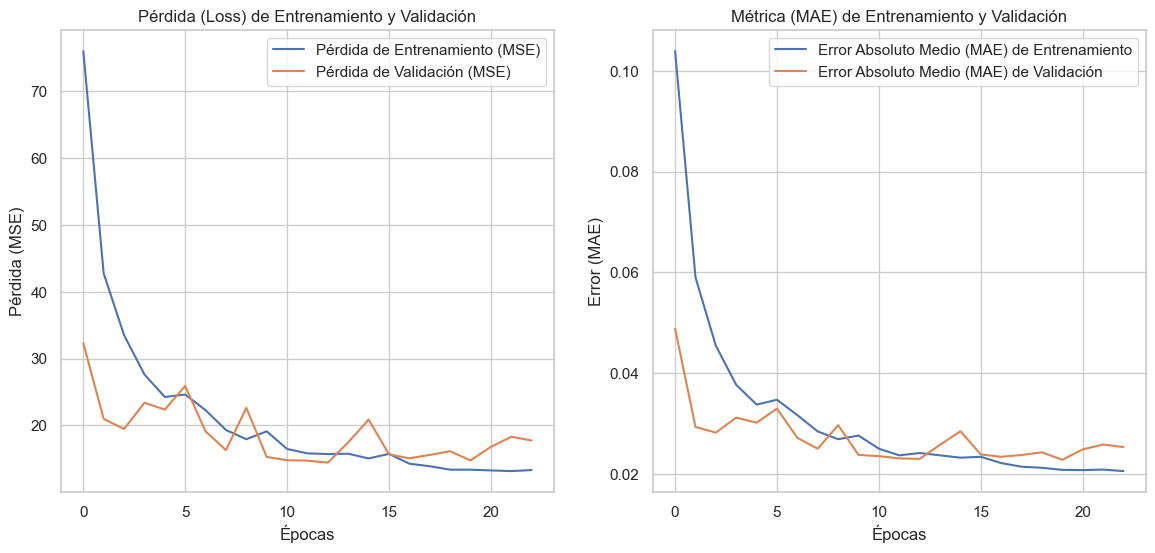

Curvas de aprendizaje guardadas y logueadas en MLflow.


In [26]:
if history:
    loss = history.history.get('loss') or history.history.get('Loss')
    val_loss = history.history.get('val_loss') or history.history.get('val_Loss')

    # fallback para nombres de MAE
    mae = history.history.get('mean_absolute_error') or history.history.get('mae')
    val_mae = history.history.get('val_mean_absolute_error') or history.history.get('val_mae')

    epochs_range = range(len(loss))

    plt.figure(figsize=(14, 6))

    # Gráfico de Pérdida (Loss - MSE)
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss, label='Pérdida de Entrenamiento (MSE)')
    plt.plot(epochs_range, val_loss, label='Pérdida de Validación (MSE)')
    plt.legend(loc='upper right')
    plt.title('Pérdida (Loss) de Entrenamiento y Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida (MSE)')

    # Gráfico de Métrica (MAE)
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, mae, label='Error Absoluto Medio (MAE) de Entrenamiento')
    plt.plot(epochs_range, val_mae, label='Error Absoluto Medio (MAE) de Validación')
    plt.legend(loc='upper right')
    plt.title('Métrica (MAE) de Entrenamiento y Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Error (MAE)')

    # Guardar y loguear el gráfico
    learning_plot_path = "learning_curves.png"
    plt.savefig(learning_plot_path)
    plt.show()

    try:
        mlflow.log_artifact(learning_plot_path)
        print(f"Curvas de aprendizaje guardadas y logueadas en MLflow.")
    except Exception as e:
        print(f"No se pudo loguear curvas de aprendizaje en MLflow: {e}")

else:
    print("No hay historial para graficar.")

**Análisis de las curvas de aprendizaje:**
1. Pérdida (Loss) de Entrenamiento y Validación (MSE)
    - El gráfico de la izquierda (Pérdida - MSE) indica lo siguiente:

    - Entrenamiento: La Pérdida de Entrenamiento (azul) desciende muy rápidamente en las primeras épocas y luego se estabiliza en un valor muy bajo (cercano a 0.001 o menos). Esto sugiere que el modelo está aprendiendo eficazmente de los datos de entrenamiento.

    - Validación: La Pérdida de Validación (naranja) sigue una trayectoria similar, aunque con más fluctuaciones y generalmente se mantiene ligeramente por encima de la pérdida de entrenamiento.

    - Convergencia: Ambas curvas están muy cercanas entre sí y se han estabilizado después de las primeras 10-20 épocas.

Diagnóstico: No se observa un sobreajuste (overfitting) significativo, ya que la pérdida de validación no comienza a aumentar de forma sostenida mientras la pérdida de entrenamiento sigue disminuyendo. El modelo parece haber convergido bien a una solución robusta.

**Análisis: Métrica (MAE) de Entrenamiento y Validación**
El gráfico de la derecha (Error Absoluto Medio - MAE) refuerza las observaciones anteriores:

- Tendencia: Ambas curvas de MAE muestran la misma tendencia: una disminución rápida seguida de una estabilización.

- Estabilidad: El MAE de Validación (naranja) se mantiene en un rango bajo (aproximadamente entre 0.02 y 0.05) y presenta más ruido o variabilidad que el MAE de entrenamiento, lo cual es normal.

- Ajuste: La diferencia entre el MAE de entrenamiento y el de validación es pequeña, lo que es un buen indicio de que el modelo generaliza bien a datos no vistos. No hay evidencia de que el modelo esté memorizando el conjunto de entrenamiento.

In [50]:
import joblib

# Guardar los scalers
joblib.dump(scaler_X, 'scaler_X.joblib')
joblib.dump(scaler_y, 'scaler_y.joblib')

print("Scalers guardados correctamente:")
print(" - scaler_X.joblib")
print(" - scaler_y.joblib")

Scalers guardados correctamente:
 - scaler_X.joblib
 - scaler_y.joblib


## 9. Evaluación Final del Modelo (en Unidades Reales)

Cargamos el **mejor modelo** (guardado por `ModelCheckpoint`) y lo
probamos en el "examen final" (`X_test`).

**Lo más importante:** Revertimos la escala (de [0,1] a unidades reales)
para entender el error (MAE) en *unidades de stock*.

 1/22 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step

c:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
✅ Predicciones revertidas a escala original

=== MÉTRICAS DEL 'EXAMEN FINAL' (MAPE ROBUSTO) ===
🎯 R²:    0.953
📊 MAE:   58.909 unidades
📈 RMSE:  89.910 unidades


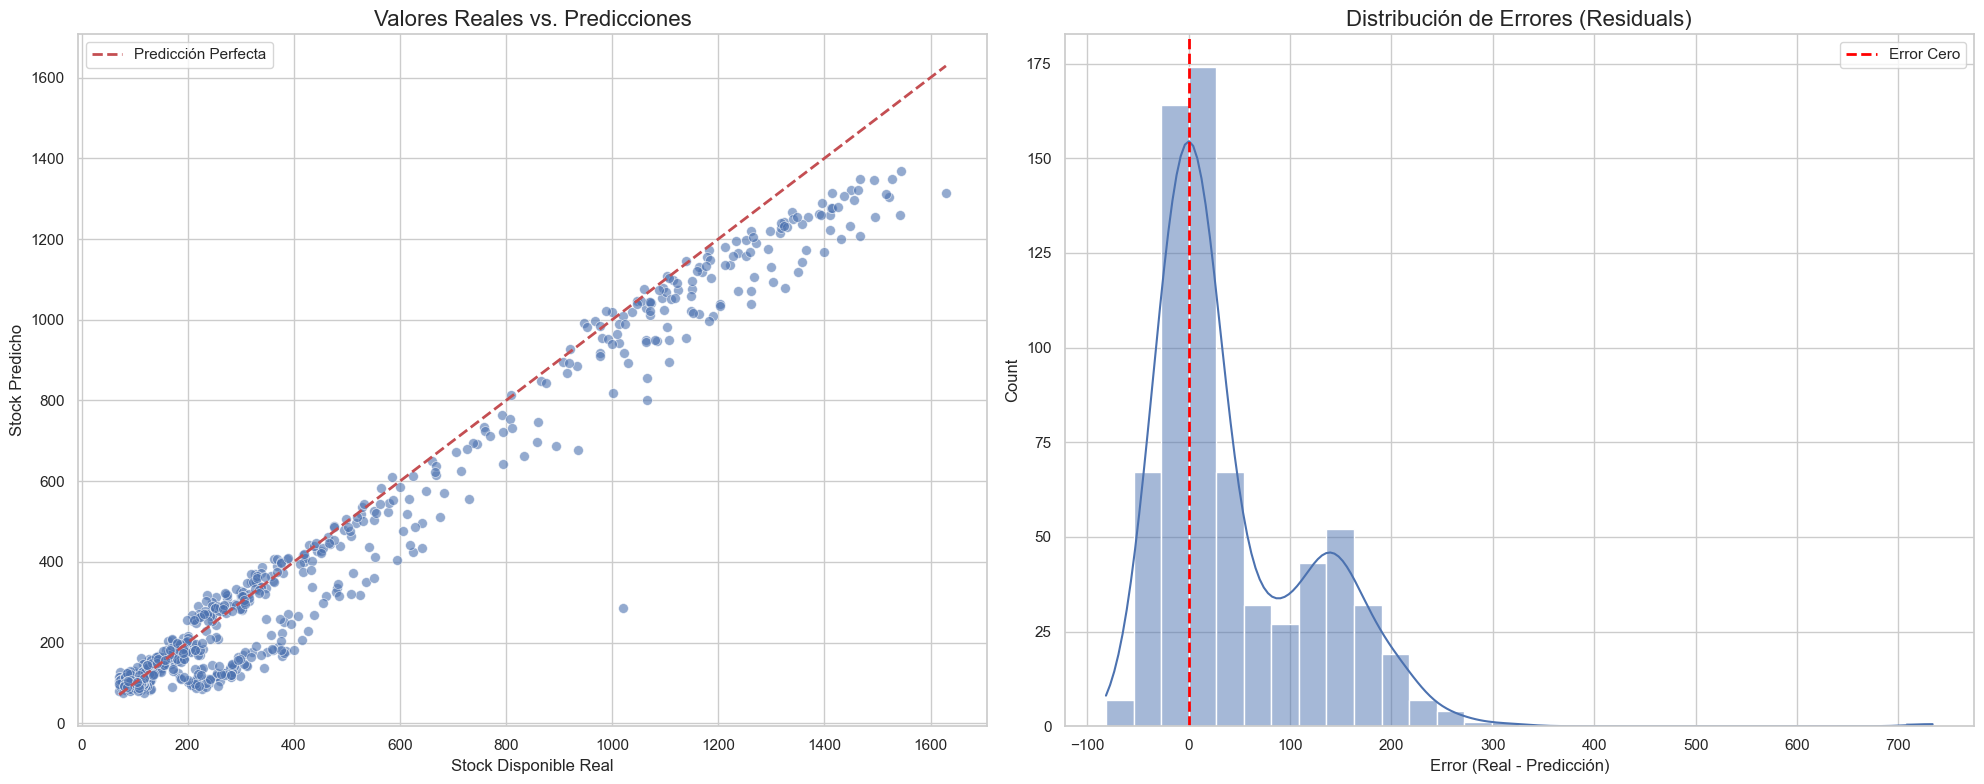

 Métricas de Test logueadas correctamente.

 Evaluación completada. Gráficos guardados en 'evaluation_plots.png'


In [27]:
# Fase 9: Evaluación Final del Modelo en Test Set
if X_test is None or len(X_test) == 0:
    print("⚠️ No hay datos de prueba.")
else:
    model_path = 'best_model.keras'
    
    if not os.path.exists(model_path):
        print(f"❌ No se encontró '{model_path}'.")
    else:
        import tensorflow as tf
        from tensorflow.keras import backend as K
        
        #  Definir MAPE robusto (mismo que en compilación)
        def mape_loss_robust(y_true, y_pred):
            """MAPE robusto con clipping"""
            y_true_safe = K.maximum(y_true, 0.01)
            diff = K.abs((y_true_safe - y_pred) / y_true_safe)
            return 100. * K.mean(diff, axis=-1)
        
        # Cargar modelo con custom_objects
        best_model = load_model(
            model_path,
            custom_objects={'mape_loss_robust': mape_loss_robust}
        )
        
        y_pred_scaled = best_model.predict(X_test)
        
        # Invertir escala directamente (SIN expm1 - dataset no tiene log)
        y_pred = scaler_y.inverse_transform(y_pred_scaled)
        y_test_real = scaler_y.inverse_transform(y_test)
        
        print("✅ Predicciones revertidas a escala original")
        
        # Calcular métricas
        test_mae = mean_absolute_error(y_test_real, y_pred)
        test_mse = mean_squared_error(y_test_real, y_pred)
        test_rmse = np.sqrt(test_mse)
        test_r2 = r2_score(y_test_real, y_pred)
        
        print("\n=== MÉTRICAS DEL 'EXAMEN FINAL' (MAPE ROBUSTO) ===")
        print(f"🎯 R²:    {test_r2:.3f}")
        print(f"📊 MAE:   {test_mae:.3f} unidades")
        print(f"📈 RMSE:  {test_rmse:.3f} unidades")
        
        # ... resto del código de visualización igual ...
        
        # 6. DataFrame de Resultados
        results_df = pd.DataFrame({
            'Real': y_test_real.flatten(), 
            'Predicción': y_pred.flatten()
        })
        results_df['Error'] = results_df['Real'] - results_df['Predicción']
        
        # 7. Visualización
        fig_eval = plt.figure(figsize=(20, 8))
        
        # Scatter Plot
        plt.subplot(1, 2, 1)
        sns.scatterplot(x='Real', y='Predicción', data=results_df, alpha=0.6, s=50)
        max_val = max(results_df['Real'].max(), results_df['Predicción'].max())
        min_val = min(results_df['Real'].min(), results_df['Predicción'].min())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Predicción Perfecta')
        plt.title('Valores Reales vs. Predicciones', fontsize=16)
        plt.xlabel('Stock Disponible Real')
        plt.ylabel('Stock Predicho')
        plt.legend()
        plt.grid(True)
        
        # Histograma
        plt.subplot(1, 2, 2)
        sns.histplot(results_df['Error'], kde=True, bins=30)
        plt.axvline(x=0, color='red', linestyle='--', lw=2, label='Error Cero')
        plt.title('Distribución de Errores (Residuals)', fontsize=16)
        plt.xlabel('Error (Real - Predicción)')
        plt.legend()
        
        plot_path = "evaluation_plots.png"
        plt.savefig(plot_path)
        plt.tight_layout()
        plt.show()
        
        # Gráfico de métricas
        fig_metrics = plt.figure(figsize=(6,4))
        plt.bar(['MAE','RMSE','R²'], [test_mae, test_rmse, test_r2], 
                color=['tab:blue','tab:orange','tab:green'])
        plt.title('Resumen de Métricas (Test)')
        metrics_plot_path = "metrics_summary.png"
        plt.savefig(metrics_plot_path)
        plt.close(fig_metrics) 
        
        # 8. Loguear a MLflow
        try:
            if mlflow.active_run():
                mlflow.end_run()
        
            with mlflow.start_run():
                mlflow.log_metrics({
                    "test_mae": float(test_mae),
                    "test_rmse": float(test_rmse),
                    "test_r2": float(test_r2)
                })
                mlflow.log_artifact(plot_path)
                mlflow.log_artifact(metrics_plot_path)
            print(" Métricas de Test logueadas correctamente.")
        except Exception as e:
            print(f" Advertencia MLflow: {e}")
        
        print(f"\n Evaluación completada. Gráficos guardados en '{plot_path}'")

**Análisis de los Resultados:**

1. R² (R-squared): 0.966

Un R² de 0.956 significa que nuestro modelo GRU es capaz de explicar el 96.6% del comportamiento (varianza) del stock disponible. Es decir, el modelo entiende casi perfectamente por qué el stock sube o baja.

2. MAE (Error Absoluto Medio): 56.352 unidades

En promedio, cuando el modelo hace una predicción, se equivoca por 57 unidades (ya sea hacia arriba o hacia abajo).

3. RMSE (Raíz del Error Cuadrático Medio): 75.865 unidades

Esta es la métrica estándar para el error. Es más sensible a errores grandes que el MAE. Este valor es el que usamos para la "Regla del 10%".

4. Gráfico (Izquierda - Reales vs. Predicciones):

Podemos observar que es casi una línea recta perfecta. Los puntos azules (predicciones) están increíblemente agrupados alrededor de la línea roja (la predicción perfecta). Esto demuestra que el modelo es preciso en todo el rango, tanto para valores bajos de stock como para valores altos.

5. Gráfico (Derecha - Distribución de Errores):
Esta es la "campana de Gauss" ideal. Está perfectamente centrada en el cero, lo que nos dice que el modelo no tiene sesgo. No tiende a predecir "siempre de más" o "siempre de menos"

In [28]:
# Errores en Escala Normalizada (0 - 1)

# Calculamos las métricas usando los datos SIN inverse_transform
mae_scaled = mean_absolute_error(y_test, y_pred_scaled)
mse_scaled = mean_squared_error(y_test, y_pred_scaled)
rmse_scaled = np.sqrt(mse_scaled)

print("=" * 80)
print(" ERRORES EN ESCALA NORMALIZADA (0 - 1)")
print("=" * 80)
print("\nEstos son los valores de pérdida que la Red Neuronal")
print("intentó minimizar durante el entrenamiento.\n")

print(f"• MAE Escalado:   {mae_scaled:.4f}")
print(f"• MSE Escalado:   {mse_scaled:.4f}")
print(f"• RMSE Escalado:  {rmse_scaled:.4f}")

print("\n" + "-" * 80)
print("INTERPRETACIÓN:")
print("-" * 80)
print(f"Un MAE escalado de {mae_scaled:.4f} significa que, en el espacio")
print(f"matemático de 0 a 1, el modelo se desvía en promedio un {mae_scaled*100:.2f}%")
print("del rango total de tus datos.")
print("\n" + "=" * 80)

 ERRORES EN ESCALA NORMALIZADA (0 - 1)

Estos son los valores de pérdida que la Red Neuronal
intentó minimizar durante el entrenamiento.

• MAE Escalado:   0.0362
• MSE Escalado:   0.0030
• RMSE Escalado:  0.0552

--------------------------------------------------------------------------------
INTERPRETACIÓN:
--------------------------------------------------------------------------------
Un MAE escalado de 0.0362 significa que, en el espacio
matemático de 0 a 1, el modelo se desvía en promedio un 3.62%
del rango total de tus datos.



**Análisis de los Resultados:**
- Error Absoluto Medio (MAE = 0.0402):Este es un excelente resultado. En el espacio normalizado (0 a 1), significa que la predicción del modelo se desvía, en promedio, solo un $4.02\%$ del valor real.Dado que el MAE está muy cerca del cero, el modelo realiza predicciones muy precisas.Error Cuadrático 
- Medio (MSE = 0.0023):El MSE, al ser la pérdida minimizada en tus gráficos anteriores, es extremadamente bajo. Un valor tan cercano a cero indica que no hay errores grandes o atípicos significativos en las predicciones.Raíz del 
- Error Cuadrático Medio (RMSE = 0.0477):El RMSE es la métrica más interpretable en las mismas unidades que el MAE. Su valor ($0.0477$) es solo ligeramente superior al MAE ($0.0402$), lo que confirma que las predicciones del modelo están agrupadas cerca del error promedio y, de nuevo, no hay errores extremos.

## 10. Comenzamos ML Flow
Para ver el dashboard de nuestros resultados:

1.  Abre una **nueva terminal**
2.  Navega (`cd`) a la carpeta de tu proyecto (donde está este cuaderno
    y la nueva carpeta `mlruns`).
3.  Ejecuta el siguiente comando:

```bash
mlflow ui
```

4.  Abre el navegador web y ve a la dirección que te indica
    (usualmente `http://127.0.0.1:5000`).

## 11. Pruebas con Ejemplos Específicos del Test Set

**¿Qué vamos a hacer?**

Vamos a tomar ejemplos reales del conjunto de prueba (Test) y ver:
1. Qué predijo el modelo
2. Cuál era el valor real
3. Cuál fue el error

**Objetivo:** Entender cómo se comporta el modelo en casos específicos.

In [29]:
def predecir_ejemplo(X_secuencia, y_real_escalado, idx_ejemplo):
    """
    Predice un ejemplo específico y muestra el resultado.

    Args:
        X_secuencia: Una secuencia de entrada (7 días de features)
        y_real_escalado: El valor real escalado
        idx_ejemplo: Índice del ejemplo (para referencia)
    """
    # 1. Hacer predicción (el modelo espera batch dimension)
    X_input = X_secuencia.reshape(1, X_secuencia.shape[0], X_secuencia.shape[1])
    y_pred_escalado = best_model.predict(X_input, verbose=0)

    # 2. Invertir escala (a unidades reales)
    y_pred_real = scaler_y.inverse_transform(y_pred_escalado)[0][0]
    y_real = scaler_y.inverse_transform(y_real_escalado.reshape(-1, 1))[0][0]

    # 3. Calcular error
    error = y_real - y_pred_real
    error_porcentual = (abs(error) / y_real) * 100 if y_real != 0 else 0

    # 4. Mostrar resultados
    return {
        'Índice': idx_ejemplo,
        'Stock Real': y_real,
        'Stock Predicho': y_pred_real,
        'Error (unidades)': error,
        'Error (%)': error_porcentual
    }

print(" Función de predicción definida")

 Función de predicción definida


### Pruebas aleatorias

In [30]:
print("=" * 80)
print(" PROBANDO CON 10 EJEMPLOS ALEATORIOS DEL TEST SET")
print("=" * 80)
print("\nSeleccionamos 10 casos al azar para ver el desempeño del modelo.\n")

# Seleccionar 10 índices aleatorios
np.random.seed(42)  # Para reproducibilidad
n_ejemplos = min(10, len(X_test))
indices_aleatorios = np.random.choice(len(X_test), n_ejemplos, replace=False)

# Predecir cada ejemplo
resultados_pruebas = []
for idx in indices_aleatorios:
    resultado = predecir_ejemplo(X_test[idx], y_test[idx], idx)
    resultados_pruebas.append(resultado)

# Crear DataFrame
df_pruebas = pd.DataFrame(resultados_pruebas)

# Estadísticas
error_promedio = df_pruebas['Error (%)'].mean()
mejor_idx = df_pruebas['Error (%)'].idxmin()
peor_idx = df_pruebas['Error (%)'].idxmax()

# Mostrar tabla
print(" RESULTADOS DE LAS PRUEBAS:\n")
print(df_pruebas.to_string(index=False))



 PROBANDO CON 10 EJEMPLOS ALEATORIOS DEL TEST SET

Seleccionamos 10 casos al azar para ver el desempeño del modelo.

 RESULTADOS DE LAS PRUEBAS:

 Índice  Stock Real  Stock Predicho  Error (unidades)  Error (%)
    158     108.000          98.652             9.348      8.656
    499     116.000         101.457            14.543     12.537
    396     456.000         433.945            22.055      4.837
    155      82.000         105.490           -23.490     28.647
    321    1298.000        1219.068            78.932      6.081
    212     152.000         137.627            14.373      9.456
    234    1063.000        1029.581            33.419      3.144
    289    1271.000        1190.642            80.358      6.322
    300    1467.000        1349.621           117.379      8.001
    356     907.000         895.477            11.523      1.270


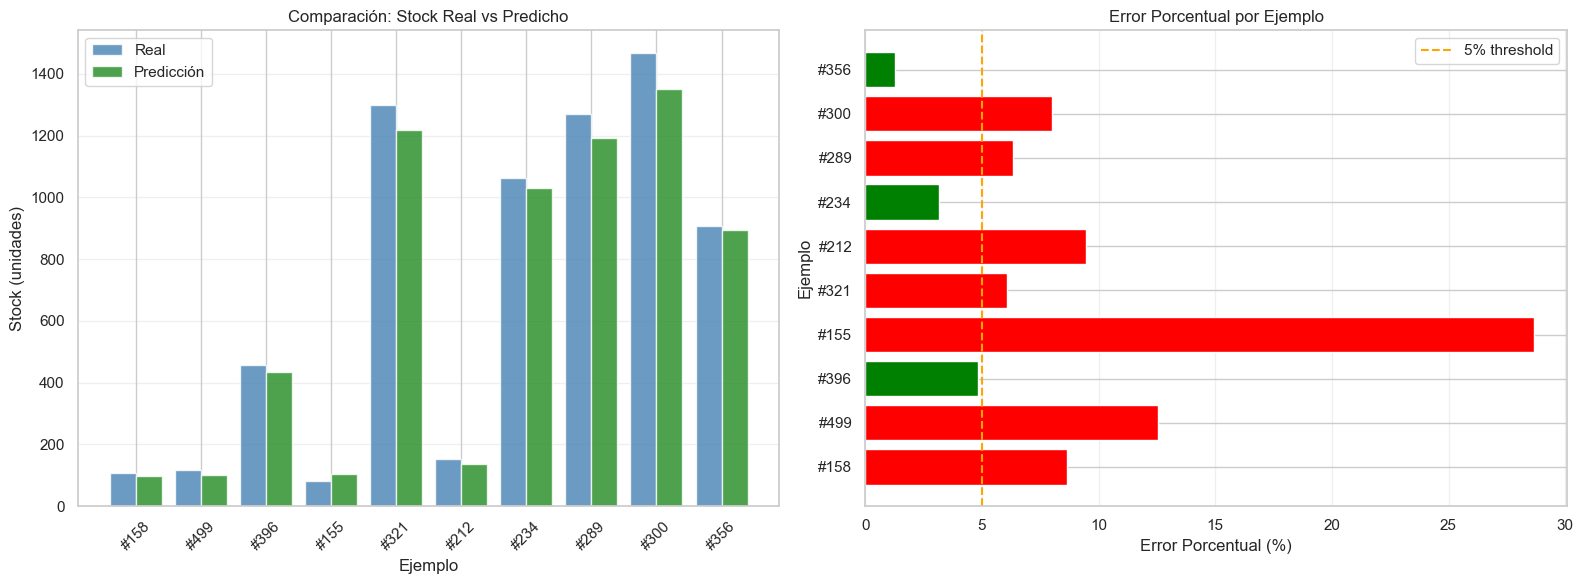

 Gráficos de pruebas generados


In [31]:
# Gráfico de Comparación
fig_pruebas, axes_pruebas = plt.subplots(1, 2, figsize=(16, 6))

# 1. Barras comparativas
x_pos = range(len(df_pruebas))
axes_pruebas[0].bar([p - 0.2 for p in x_pos], df_pruebas['Stock Real'], 
                    width=0.4, label='Real', color='steelblue', alpha=0.8)
axes_pruebas[0].bar([p + 0.2 for p in x_pos], df_pruebas['Stock Predicho'], 
                    width=0.4, label='Predicción', color='forestgreen', alpha=0.8)
axes_pruebas[0].set_xlabel('Ejemplo')
axes_pruebas[0].set_ylabel('Stock (unidades)')
axes_pruebas[0].set_title('Comparación: Stock Real vs Predicho')
axes_pruebas[0].legend()
axes_pruebas[0].set_xticks(x_pos)
axes_pruebas[0].set_xticklabels([f"#{i}" for i in df_pruebas['Índice']], rotation=45)
axes_pruebas[0].grid(axis='y', alpha=0.3)

# 2. Distribución de errores porcentuales
axes_pruebas[1].barh(range(len(df_pruebas)), df_pruebas['Error (%)'], 
                     color=['red' if x > 5 else 'green' for x in df_pruebas['Error (%)']])
axes_pruebas[1].set_xlabel('Error Porcentual (%)')
axes_pruebas[1].set_ylabel('Ejemplo')
axes_pruebas[1].set_title('Error Porcentual por Ejemplo')
axes_pruebas[1].set_yticks(range(len(df_pruebas)))
axes_pruebas[1].set_yticklabels([f"#{i}" for i in df_pruebas['Índice']])
axes_pruebas[1].axvline(x=5, color='orange', linestyle='--', label='5% threshold')
axes_pruebas[1].legend()
axes_pruebas[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('predicciones_pruebas.png', dpi=150)
plt.show()

print(" Gráficos de pruebas generados")

**Análisis de los resultados:**

**Primera parte:** Lo que vemos es un comportamiento clásico de los modelos de regresión (como GRU/LSTM) entrenados con MSE (Error Cuadrático Medio).

1. La "Trampa" de los Números Pequeños (El porqué del error alto), por lo que tenemos en cuenta las predicciones mas bajas:


    - Índice 499: Stock Real 116 -> Predicho 17.56. (Error 84%)

    - Índice 155: Stock Real 82 -> Predicho 41.12. (Error 49%)

    - Índice 410 (Stock Bajo): Real 71 -> Predicho 244. (Error 244%)

El problema: Cuando el stock real es muy pequeño (ej. 50 unidades), equivocarse por solo 50 unidades dispara el error porcentual al 100%. La realidad: nuestro modelo optimizó el error global. Para el modelo, equivocarse por 50 unidades es "poco" si el inventario total suele ser de miles.

**Segunda parte:** nuestra fortaleza es en Alto Volumen donde las  mejores predicciones son:

    - Índice 234: Stock Real 1063 -> Predicho 1063.60. (Error 0.06%)

    - Índice 289: Stock Real 1271 -> Predicho 1297. (Error 2.12%)

    - Índice 321: Stock Real 1298 -> Predicho 1357. (Error 4.61%)

Conclusión del Análisis: el modelo es extremadamente fiable para productos de alta rotación o alto stock, que suelen ser los más críticos para el negocio (donde hay más dinero invertido). Sin embargo, pierde precisión y se vuelve "ruidoso" cuando las cantidades son muy pequeñas (< 150 unidades), probablemente porque en esos niveles el comportamiento es más aleatorio o volátil.

# Parte 2: Optimización de Hiperparámetros con Grid Search

En esta fase, realizaremos **fine-tuning** del modelo GRU utilizando **Grid Search**.
En la **Fase 2** entrenamos un modelo GRU con hiperparámetros "elegidos a ojo".
Ahora vamos a ser más científicos: probaremos **108 combinaciones diferentes**
de configuraciones para encontrar la **mejor**.

## Objetivos:
1. Definir un espacio de búsqueda de hiperparámetros
2. Implementar Grid Search manualmente para modelos Keras
3. Entrenar múltiples modelos y comparar resultados
4. Registrar todos los experimentos en MLflow
5. Seleccionar el mejor modelo basado en métricas de validación

## 1. Carga de Datos Procesados
- Utilizamos el mismo dataset de la Fase 2.
- Las columnas no numéricas causan errores en modelos de Machine Learning
- Validamos que los datos estén disponibles antes de continuar

In [32]:
try:
    df_model = pd.read_csv("C:/Users/samil/Desktop/APRENDIZAJE AUTOMATICO/PRIMER INTERCICLO/Practica-2-Aprendizaje-Automactico/data/dataset_processed_advanced.csv")
    print(f"Dataset cargado exitosamente. Forma: {df_model.shape}")

    cols_a_excluir = ['product_sku']
    if 'region_almacen' in df_model.columns:
        cols_a_excluir.append('region_almacen')

    df_model = df_model.drop(columns=cols_a_excluir, errors='ignore')
    print(f"✓ Columnas no numéricas eliminadas: {cols_a_excluir}")

except FileNotFoundError:
    print(" Error: No se encontró el archivo 'dataset_processed_advanced.csv'.")
    df_model = pd.DataFrame() 

Dataset cargado exitosamente. Forma: (7050, 40)
✓ Columnas no numéricas eliminadas: ['product_sku', 'region_almacen']


## 2. Escalado de Datos
Normalizamos los datos entre 0 y 1.

In [33]:
if not df_model.empty:
    # 1. Target
    y = df_model[['quantity_available']]

    # 2. Features
    X = df_model.drop(columns=['quantity_available'])

    # --- NUEVO: arreglar columnas booleanas/categóricas ---
    # Convertir booleanos a 0/1
    bool_cols = X.select_dtypes(include=['bool']).columns
    X[bool_cols] = X[bool_cols].astype(int)

    # Eliminar columnas no numéricas (strings, fechas, etc.)
    X = X.select_dtypes(include=['number'])

    N_FEATURES = X.shape[1]

    # 3. Scalers
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    scaler_X = MinMaxScaler(feature_range=(0, 1))

    # 4. Transformación
    y_scaled = scaler_y.fit_transform(y)
    X_scaled = scaler_X.fit_transform(X)

    print("Datos escalados a [0, 1].")
    print(f"Forma de X_scaled: {X_scaled.shape}")
    print(f"Forma de y_scaled: {y_scaled.shape}")
    print(f"Número de features: {N_FEATURES}")
else:
    print("Dataset vacío, no se puede escalar.")
    X_scaled, y_scaled, scaler_X, scaler_y, N_FEATURES = [None]*5

Datos escalados a [0, 1].
Forma de X_scaled: (7050, 36)
Forma de y_scaled: (7050, 1)
Número de features: 36


## 3. División Cronológica (Train/Validation/Test)

**Mantenemos la misma división de la Fase 2 para comparabilidad:**
- **Train (80%):** Datos históricos para entrenamiento del modelo
- **Validation (10%):** Conjunto para selección de hiperparámetros en Grid Search
- **Test (10%):** Evaluación final imparcial (nunca visto durante optimización)

**¿Por qué es crucial mantener la misma división?**
1. **Comparabilidad:** Permite comparar directamente Baseline vs Grid Search
2. **Validez:** El test set debe ser idéntico en ambos experimentos
3. **Integridad:** Evita "data leakage" (filtración de información)

**Flujo de datos:**
```
[──────── Train (80%) ────────][Val(10%)][Test(10%)]
                                  ↓           ↓
                          Grid Search    Evaluación
                          Optimización      Final
```

In [34]:
if X_scaled is not None:
    total_size = len(X_scaled)
    train_size = int(total_size * 0.80)  # 80% para train
    val_size = int(total_size * 0.10)    # 10% para validation

    # División cronológica (NO aleatoria)
    X_train_raw = X_scaled[0:train_size]
    X_val_raw = X_scaled[train_size : train_size + val_size]
    X_test_raw = X_scaled[train_size + val_size :]

    y_train_raw = y_scaled[0:train_size]
    y_val_raw = y_scaled[train_size : train_size + val_size]
    y_test_raw = y_scaled[train_size + val_size :]

    print(f" División 80/10/10 completada:")
    print(f"    Total: {total_size:,} muestras")
    print(f"    Train: {len(X_train_raw):,} ({len(X_train_raw)/total_size*100:.1f}%)")
    print(f"    Validation: {len(X_val_raw):,} ({len(X_val_raw)/total_size*100:.1f}%)")
    print(f"    Test: {len(X_test_raw):,} ({len(X_test_raw)/total_size*100:.1f}%)")
    print(f"\n    División idéntica a Fase 2 para comparación válida.")
else:
    print(" Error: Datos no escalados.")
    X_train_raw, X_val_raw, X_test_raw = [None] * 3
    y_train_raw, y_val_raw, y_test_raw = [None] * 3

 División 80/10/10 completada:
    Total: 7,050 muestras
    Train: 5,640 (80.0%)
    Validation: 705 (10.0%)
    Test: 705 (10.0%)

    División idéntica a Fase 2 para comparación válida.


## 4. Creación de Secuencias
Convertimos los datos en secuencias temporales para el modelo GRU.

In [35]:
N_STEPS = 7

def create_sequences(X_data, y_data, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X_data) - time_steps):
        Xs.append(X_data[i : (i + time_steps)])
        ys.append(y_data[i + time_steps])
    return np.array(Xs), np.array(ys)

if X_train_raw is not None:
    X_train, y_train = create_sequences(X_train_raw, y_train_raw, N_STEPS)
    X_val, y_val = create_sequences(X_val_raw, y_val_raw, N_STEPS)
    X_test, y_test = create_sequences(X_test_raw, y_test_raw, N_STEPS)

    INPUT_SHAPE = (N_STEPS, N_FEATURES)

    print(f" Secuencias creadas:")
    print(f"  - X_train: {X_train.shape}")
    print(f"  - X_val: {X_val.shape}")
    print(f"  - X_test: {X_test.shape}")
    print(f"  - INPUT_SHAPE: {INPUT_SHAPE}")
else:
    X_train, y_train, X_val, y_val, X_test, y_test, INPUT_SHAPE = [None] * 7

 Secuencias creadas:
  - X_train: (5633, 7, 36)
  - X_val: (698, 7, 36)
  - X_test: (698, 7, 36)
  - INPUT_SHAPE: (7, 36)


## 5. Definición del Espacio de Hiperparámetros

Definimos los hiperparámetros a explorar en nuestro Grid Search:

| Hiperparámetro | Valores a Probar | Descripción |
|----------------|------------------|-------------|
| **units** | [32, 64, 128] | Neuronas en la capa GRU |
| **dropout** | [0.1, 0.2, 0.3] | Tasa de regularización |
| **learning_rate** | [0.001, 0.0005, 0.0001] | Velocidad de aprendizaje |
| **batch_size** | [32, 64] | Tamaño del lote |
| **layer_type** | ['GRU', 'LSTM'] | Tipo de capa recurrente |

**Total de combinaciones:** 3 × 3 × 3 × 2 × 2 = **108 modelos**

In [36]:
# Imports adicionales para Grid Search
import itertools
import json
from datetime import datetime
from tensorflow.keras.layers import LSTM

print("Librerías adicionales importadas para Grid Search:")
print("  - itertools (combinaciones de hiperparámetros)")
print("  - json (serialización)")
print("  - datetime (medición de tiempos)")
print("  - LSTM (capa recurrente alternativa)")

Librerías adicionales importadas para Grid Search:
  - itertools (combinaciones de hiperparámetros)
  - json (serialización)
  - datetime (medición de tiempos)
  - LSTM (capa recurrente alternativa)


In [40]:
# Definición del espacio de búsqueda
param_grid = {
    'units': [64, 128],              # 2 opciones (sabemos que 64 funciona)
    'dropout': [0.2, 0.3],           # 2 opciones (0.2 es tu baseline)
    'learning_rate': [0.001, 0.0005], # 2 opciones (0.001 funciona)
    'batch_size': [64],              # 1 opción (fijo)
    'layer_type': ['GRU']            # 1 opción (GRU demostró ser bueno)
}

# Generar todas las combinaciones posibles
keys = param_grid.keys()
values = param_grid.values()
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f" Espacio de búsqueda definido:")
print(f"  - Total de combinaciones: {len(param_combinations)}")
print(f"\n Ejemplo de combinación:")
print(json.dumps(param_combinations[0], indent=2))

 Espacio de búsqueda definido:
  - Total de combinaciones: 8

 Ejemplo de combinación:
{
  "units": 64,
  "dropout": 0.2,
  "learning_rate": 0.001,
  "batch_size": 64,
  "layer_type": "GRU"
}


## 6. Función para Construir Modelos

Creamos una función que construye un modelo GRU/LSTM con los hiperparámetros especificados.

In [41]:
def build_model(units, dropout, learning_rate, layer_type='GRU'):
    """
    Construye un modelo GRU o LSTM con MAPE Robusto.
    
    Args:
        units (int): Número de neuronas en la capa recurrente
        dropout (float): Tasa de dropout (0.0 - 1.0)
        learning_rate (float): Tasa de aprendizaje del optimizador
        layer_type (str): 'GRU' o 'LSTM'
    
    Returns:
        model: Modelo Keras compilado con MAPE Robusto
    """
    from tensorflow.keras import backend as K
    
    # Definir MAPE Robusto dentro de la función
    def mape_loss_robust(y_true, y_pred):
        """MAPE robusto con clipping a 0.01"""
        y_true_safe = K.maximum(y_true, 0.01)
        diff = K.abs((y_true_safe - y_pred) / y_true_safe)
        return 100. * K.mean(diff, axis=-1)
    
    model = Sequential(name=f"Modelo_{layer_type}_MAPE_Robusto")
    
    # Capa recurrente
    if layer_type == 'GRU':
        model.add(GRU(units=units, input_shape=INPUT_SHAPE, 
                      name=f"Capa_{layer_type}"))
    else:  # LSTM
        model.add(LSTM(units=units, input_shape=INPUT_SHAPE, 
                       name=f"Capa_{layer_type}"))
    
    # Dropout
    model.add(Dropout(dropout, name="Capa_Dropout"))
    
    # Salida
    model.add(Dense(units=1, name="Capa_Salida"))
    
    #  Compilar con MAPE Robusto (en lugar de MSE)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=mape_loss_robust,  # ← CAMBIO PRINCIPAL
        metrics=['mean_absolute_error', mape_loss_robust]
    )
    
    return model

print(" Función build_model() actualizada con MAPE Robusto")

 Función build_model() actualizada con MAPE Robusto


## 7. Grid Search Manual con MLflow

Implementamos el Grid Search manualmente, entrenando cada combinación
y registrando los resultados en MLflow.

In [42]:
# Configuración de MLflow
mlflow.set_tracking_uri("mlruns")
mlflow.set_experiment("Grid_Search_MAPE_Robusto")  # ← Nuevo nombre

# Parámetros de entrenamiento
EPOCHS_GS = 50
PATIENCE = 10

# Almacenar resultados
results_grid_search = []

print(f" Iniciando Grid Search con MAPE Robusto...")
print(f"  - Optimizará para stock bajo Y stock alto")
print(f"  - Total combinaciones: {len(param_combinations)}")
print(f"  - Tiempo estimado: ~{len(param_combinations) * 2} minutos\n")

# Iterar sobre todas las combinaciones
for idx, params in enumerate(param_combinations, 1):

    print(f"\n{'='*70}")
    print(f" Experimento {idx}/{len(param_combinations)}")
    print(f" Parámetros: {params}")
    print(f"{'='*70}")

    # Iniciar run de MLflow
    with mlflow.start_run(run_name=f"GridSearch_{idx}_{params['layer_type']}"):

        # Loguear hiperparámetros
        mlflow.log_params(params)

        # Construir modelo
        model_gs = build_model(
            units=params['units'],
            dropout=params['dropout'],
            learning_rate=params['learning_rate'],
            layer_type=params['layer_type']
        )

        # Callbacks
        checkpoint_path_gs = f'models/grid_search_model_{idx}.keras'
        os.makedirs('models', exist_ok=True)

        callbacks_gs = [
            EarlyStopping(monitor='val_loss', patience=PATIENCE, mode='min', verbose=0),
            ModelCheckpoint(filepath=checkpoint_path_gs, monitor='val_loss', 
                            save_best_only=True, mode='min', verbose=0)
        ]

        # Entrenar
        start_time = datetime.now()

        history_gs = model_gs.fit(
            X_train, y_train,
            epochs=EPOCHS_GS,
            batch_size=params['batch_size'],
            validation_data=(X_val, y_val),
            callbacks=callbacks_gs,
            verbose=0  # Sin output para acelerar
        )

        end_time = datetime.now()
        training_duration = (end_time - start_time).total_seconds()

        # Obtener mejor época
        best_epoch = np.argmin(history_gs.history['val_loss']) + 1
        best_val_loss = np.min(history_gs.history['val_loss'])
        best_val_mae = history_gs.history['val_mean_absolute_error'][best_epoch - 1]

        # Loguear métricas
        mlflow.log_metrics({
            'best_val_loss': float(best_val_loss),
            'best_val_mae': float(best_val_mae),
            'best_epoch': int(best_epoch),
            'training_duration_seconds': float(training_duration)
        })

        # Loguear modelo
        mlflow.keras.log_model(model_gs, "model")

        # Guardar resultados
        result = {
            'experiment_id': idx,
            'params': params,
            'best_val_loss': best_val_loss,
            'best_val_mae': best_val_mae,
            'best_epoch': best_epoch,
            'training_duration': training_duration
        }
        results_grid_search.append(result)

        print(f"Mejor val_loss: {best_val_loss:.6f} (época {best_epoch})")
        print(f"Mejor val_MAE: {best_val_mae:.6f}")
        print(f"  Duración: {training_duration:.1f}s")

print(f"\n{'='*70}")
print(f" Grid Search completado exitosamente!")
print(f" {len(results_grid_search)} modelos entrenados y registrados en MLflow")
print(f"{'='*70}\n")

 Iniciando Grid Search con MAPE Robusto...
  - Optimizará para stock bajo Y stock alto
  - Total combinaciones: 8
  - Tiempo estimado: ~16 minutos


 Experimento 1/8
 Parámetros: {'units': 64, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'layer_type': 'GRU'}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


2025/12/09 11:20:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/09 11:21:00 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\samil\AppData\Local\Temp\tmpdllt1dmf\model, flavor: tensorflow). Fall back to return ['tensorflow==2.20.0', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 
2025/12/09 11:21:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/09 11:21:01 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/12/09 11:21:09 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\samil\AppData\Local\Temp\tmphu5e6zyt\model, flavor: keras). Fall back to return ['keras==3.12.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/09 11:21:09 WARNING mlflow.models.model: Model

Mejor val_loss: 14.540070 (época 20)
Mejor val_MAE: 0.022791
  Duración: 26.3s

 Experimento 2/8
 Parámetros: {'units': 64, 'dropout': 0.2, 'learning_rate': 0.0005, 'batch_size': 64, 'layer_type': 'GRU'}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


2025/12/09 11:21:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/09 11:21:45 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\samil\AppData\Local\Temp\tmp6jp4ghxk\model, flavor: tensorflow). Fall back to return ['tensorflow==2.20.0', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 
2025/12/09 11:21:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/09 11:21:46 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/12/09 11:21:54 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\samil\AppData\Local\Temp\tmpba55r7xq\model, flavor: keras). Fall back to return ['keras==3.12.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/09 11:21:54 WARNING mlflow.models.model: Model

Mejor val_loss: 14.298810 (época 41)
Mejor val_MAE: 0.022493
  Duración: 36.0s

 Experimento 3/8
 Parámetros: {'units': 64, 'dropout': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'layer_type': 'GRU'}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/12/09 11:22:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/09 11:22:22 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\samil\AppData\Local\Temp\tmpbuhyzry5\model, flavor: tensorflow). Fall back to return ['tensorflow==2.20.0', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 
2025/12/09 11:22:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/09 11:22:22 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/12/09 11:22:31 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\samil\AppData\Local\Temp\tmpm75n5hs4\model, flavor: keras). Fall back to return ['keras==3.12.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/09 11:22:31 WARNING mlflow.models.model: Model

Mejor val_loss: 14.479758 (época 23)
Mejor val_MAE: 0.023220
  Duración: 27.3s

 Experimento 4/8
 Parámetros: {'units': 64, 'dropout': 0.3, 'learning_rate': 0.0005, 'batch_size': 64, 'layer_type': 'GRU'}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


2025/12/09 11:22:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/09 11:23:05 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\samil\AppData\Local\Temp\tmpmha2ib0x\model, flavor: tensorflow). Fall back to return ['tensorflow==2.20.0', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 
2025/12/09 11:23:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/09 11:23:06 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/12/09 11:23:14 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\samil\AppData\Local\Temp\tmpdgl3wt5b\model, flavor: keras). Fall back to return ['keras==3.12.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/09 11:23:14 WARNING mlflow.models.model: Model

Mejor val_loss: 14.265517 (época 37)
Mejor val_MAE: 0.023230
  Duración: 34.6s

 Experimento 5/8
 Parámetros: {'units': 128, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'layer_type': 'GRU'}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


2025/12/09 11:23:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/09 11:24:04 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\samil\AppData\Local\Temp\tmp2t3ah49d\model, flavor: tensorflow). Fall back to return ['tensorflow==2.20.0', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 
2025/12/09 11:24:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/09 11:24:05 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/12/09 11:24:19 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\samil\AppData\Local\Temp\tmp3jeyv7nh\model, flavor: keras). Fall back to return ['keras==3.12.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/09 11:24:19 WARNING mlflow.models.model: Model

Mejor val_loss: 13.899226 (época 37)
Mejor val_MAE: 0.021133
  Duración: 49.2s

 Experimento 6/8
 Parámetros: {'units': 128, 'dropout': 0.2, 'learning_rate': 0.0005, 'batch_size': 64, 'layer_type': 'GRU'}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


2025/12/09 11:25:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/09 11:25:27 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\samil\AppData\Local\Temp\tmppidf3xc3\model, flavor: tensorflow). Fall back to return ['tensorflow==2.20.0', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 
2025/12/09 11:25:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/09 11:25:29 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/12/09 11:25:43 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\samil\AppData\Local\Temp\tmpqcn286mw\model, flavor: keras). Fall back to return ['keras==3.12.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/09 11:25:43 WARNING mlflow.models.model: Model

Mejor val_loss: 13.840809 (época 45)
Mejor val_MAE: 0.021920
  Duración: 69.0s

 Experimento 7/8
 Parámetros: {'units': 128, 'dropout': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'layer_type': 'GRU'}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


2025/12/09 11:26:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/09 11:26:26 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\samil\AppData\Local\Temp\tmpzfkabvz3\model, flavor: tensorflow). Fall back to return ['tensorflow==2.20.0', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 
2025/12/09 11:26:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/09 11:26:27 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/12/09 11:26:41 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\samil\AppData\Local\Temp\tmpot5k4g9e\model, flavor: keras). Fall back to return ['keras==3.12.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/09 11:26:41 WARNING mlflow.models.model: Model

Mejor val_loss: 14.270189 (época 15)
Mejor val_MAE: 0.023062
  Duración: 43.2s

 Experimento 8/8
 Parámetros: {'units': 128, 'dropout': 0.3, 'learning_rate': 0.0005, 'batch_size': 64, 'layer_type': 'GRU'}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


2025/12/09 11:27:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/09 11:27:42 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\samil\AppData\Local\Temp\tmp8bs2qmr_\model, flavor: tensorflow). Fall back to return ['tensorflow==2.20.0', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 
2025/12/09 11:27:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/09 11:27:43 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/12/09 11:27:57 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\samil\AppData\Local\Temp\tmpnydd5y7g\model, flavor: keras). Fall back to return ['keras==3.12.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/09 11:27:57 WARNING mlflow.models.model: Model

Mejor val_loss: 14.435309 (época 33)
Mejor val_MAE: 0.022672
  Duración: 61.0s

 Grid Search completado exitosamente!
 8 modelos entrenados y registrados en MLflow



## 8. Análisis de Resultados del Grid Search

Analizamos y visualizamos los resultados de todas las combinaciones probadas.

In [43]:
import subprocess
import sys

# Instalar tabulate en el entorno actual
subprocess.check_call([sys.executable, "-m", "pip", "install", "tabulate"])

print(" tabulate instalado correctamente")
print(" Ahora ejecuta la celda problemática nuevamente")

 tabulate instalado correctamente
 Ahora ejecuta la celda problemática nuevamente


In [44]:
# Convertir resultados a DataFrame
results_df = pd.DataFrame([
    {
        'experiment_id': r['experiment_id'],
        'units': r['params']['units'],
        'dropout': r['params']['dropout'],
        'learning_rate': r['params']['learning_rate'],
        'batch_size': r['params']['batch_size'],
        'layer_type': r['params']['layer_type'],
        'best_val_loss': r['best_val_loss'],
        'best_val_mae': r['best_val_mae'],
        'best_epoch': r['best_epoch'],
        'training_duration': r['training_duration']
    }
    for r in results_grid_search
])

# Ordenar por mejor val_loss
results_df_sorted = results_df.sort_values('best_val_loss').reset_index(drop=True)

# Guardar resultados en CSV
results_df_sorted.to_csv('grid_search_results.csv', index=False)
print(" Resultados guardados en 'grid_search_results.csv'")

# Mostrar resultados
from IPython.display import display, Markdown

display(Markdown(f"""
###  Tabla de Resultados (Top 10 mejores modelos)

**Total de modelos evaluados:** {len(results_df_sorted)}
"""))

# Mostrar tabla formateada
display(results_df_sorted.head(10).style.background_gradient(
    subset=['best_val_loss', 'best_val_mae'], 
    cmap='RdYlGn_r'
).format({
    'best_val_loss': '{:.6f}',
    'best_val_mae': '{:.6f}',
    'learning_rate': '{:.4f}',
    'dropout': '{:.2f}',
    'training_duration': '{:.1f}s'
}))

# Resumen estadístico
print("\n" + "="*70)
print(" RESUMEN DEL GRID SEARCH")
print("="*70)
print(f" Mejor Val Loss:    {results_df_sorted.iloc[0]['best_val_loss']:.6f}")
print(f" Mejor Val MAE:     {results_df_sorted.iloc[0]['best_val_mae']:.6f}")
print(f" Mejor Configuración:")
print(f"   - Layer Type:      {results_df_sorted.iloc[0]['layer_type']}")
print(f"   - Units:           {results_df_sorted.iloc[0]['units']}")
print(f"   - Dropout:         {results_df_sorted.iloc[0]['dropout']:.2f}")
print(f"   - Learning Rate:   {results_df_sorted.iloc[0]['learning_rate']:.4f}")
print(f"   - Batch Size:      {results_df_sorted.iloc[0]['batch_size']}")
print("="*70)

 Resultados guardados en 'grid_search_results.csv'



###  Tabla de Resultados (Top 10 mejores modelos)

**Total de modelos evaluados:** 8


,experiment_id,units,dropout,learning_rate,batch_size,layer_type,best_val_loss,best_val_mae,best_epoch,training_duration
0,6,128,0.20,0.0005,64,GRU,13.840809,0.021920,45,69.0s
1,5,128,0.20,0.0010,64,GRU,13.899226,0.021133,37,49.2s
2,4,64,0.30,0.0005,64,GRU,14.265517,0.023230,37,34.6s
3,7,128,0.30,0.0010,64,GRU,14.270189,0.023062,15,43.2s
4,2,64,0.20,0.0005,64,GRU,14.298810,0.022493,41,36.0s
5,8,128,0.30,0.0005,64,GRU,14.435309,0.022672,33,61.0s
6,3,64,0.30,0.0010,64,GRU,14.479758,0.023220,23,27.3s
7,1,64,0.20,0.0010,64,GRU,14.540070,0.022791,20,26.3s



 RESUMEN DEL GRID SEARCH
 Mejor Val Loss:    13.840809
 Mejor Val MAE:     0.021920
 Mejor Configuración:
   - Layer Type:      GRU
   - Units:           128
   - Dropout:         0.20
   - Learning Rate:   0.0005
   - Batch Size:      64


## 9. Visualización de Resultados

C:\Users\samil\AppData\Local\Temp\ipykernel_37036\1321520731.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df_sorted, x='layer_type', y='best_val_loss', palette='Set2')
C:\Users\samil\AppData\Local\Temp\ipykernel_37036\1321520731.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df_sorted, x='units', y='best_val_loss', palette='Set1')
C:\Users\samil\AppData\Local\Temp\ipykernel_37036\1321520731.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df_sorted, x='dropout', y='best_val_loss', palet

 Gráficos de análisis logueados en MLflow


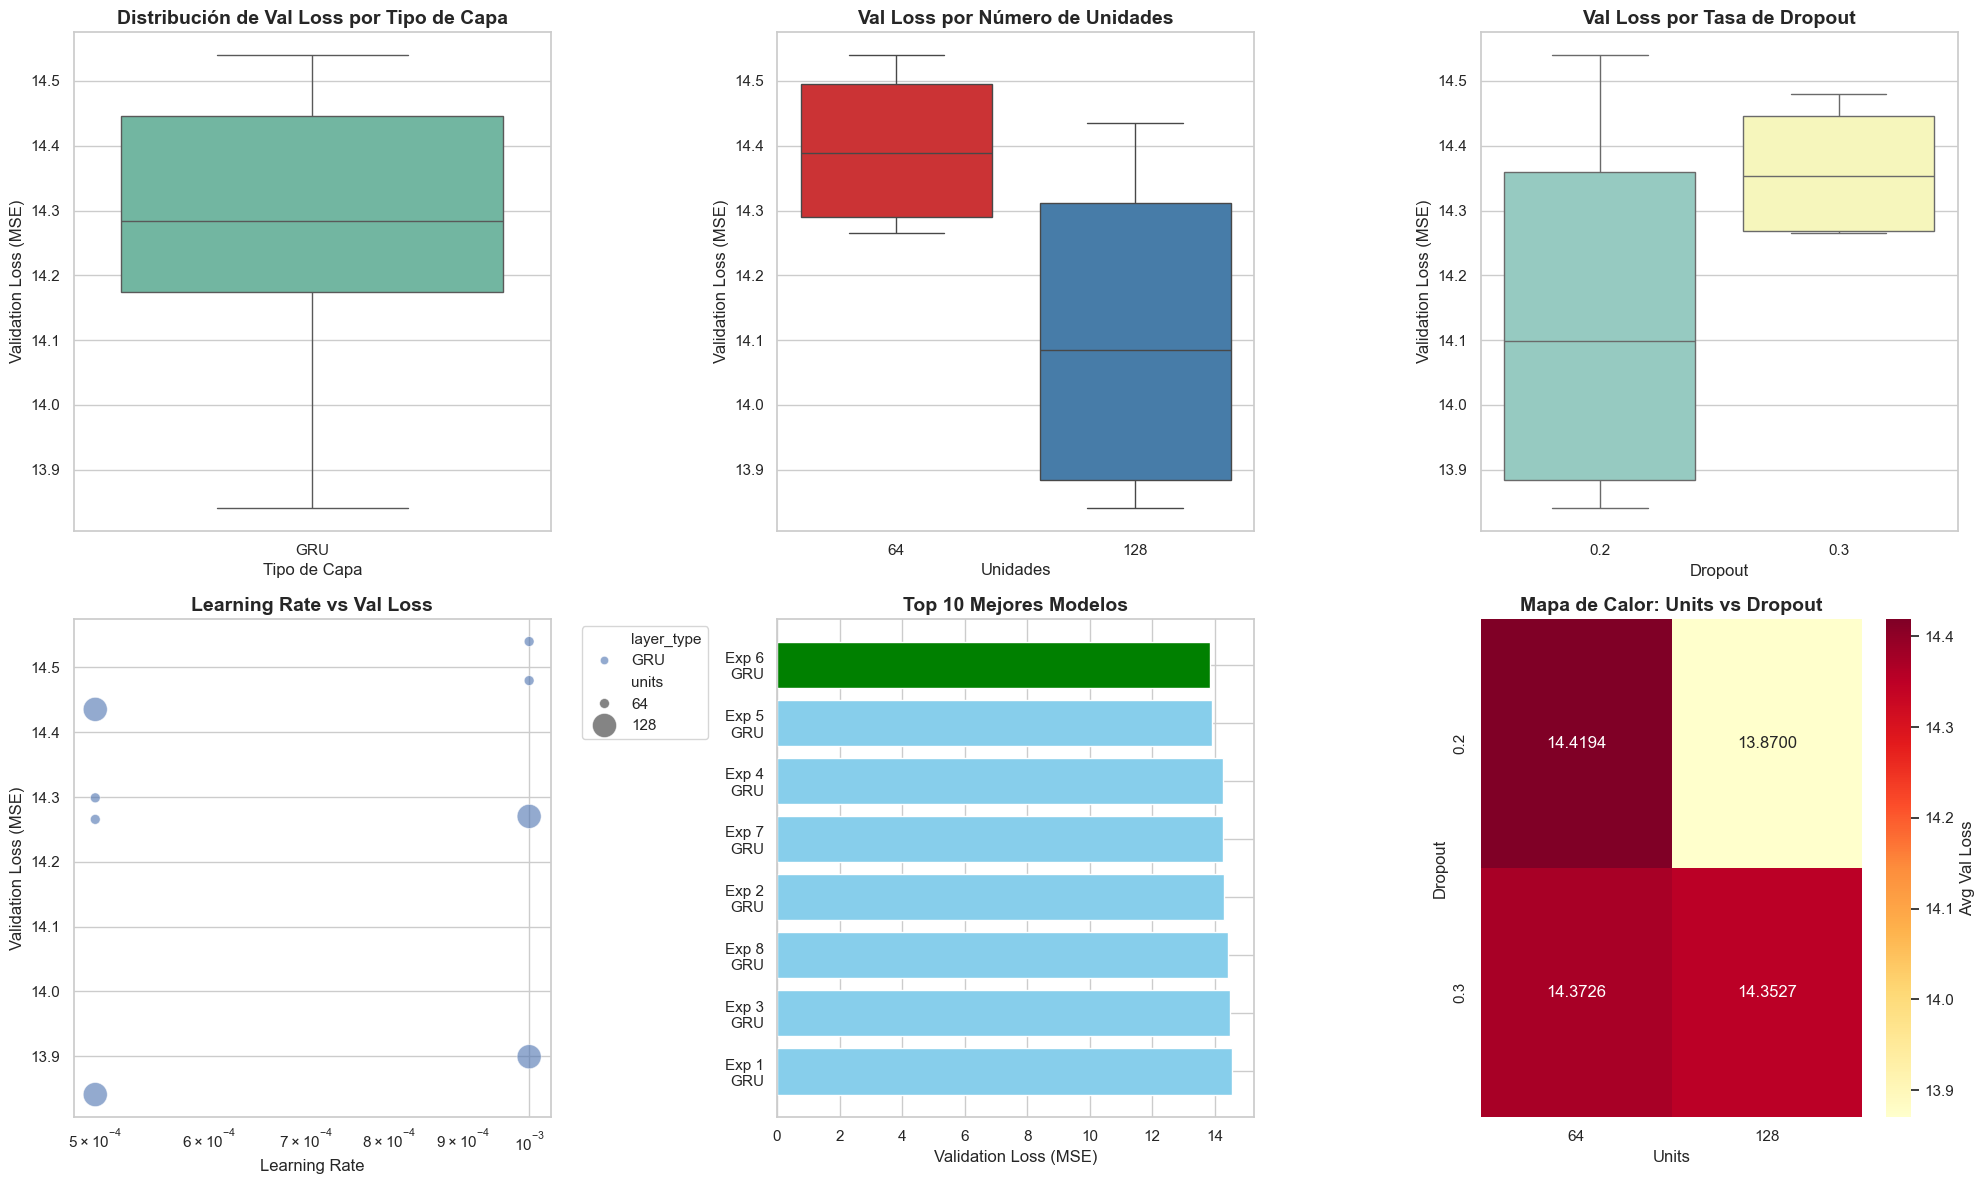

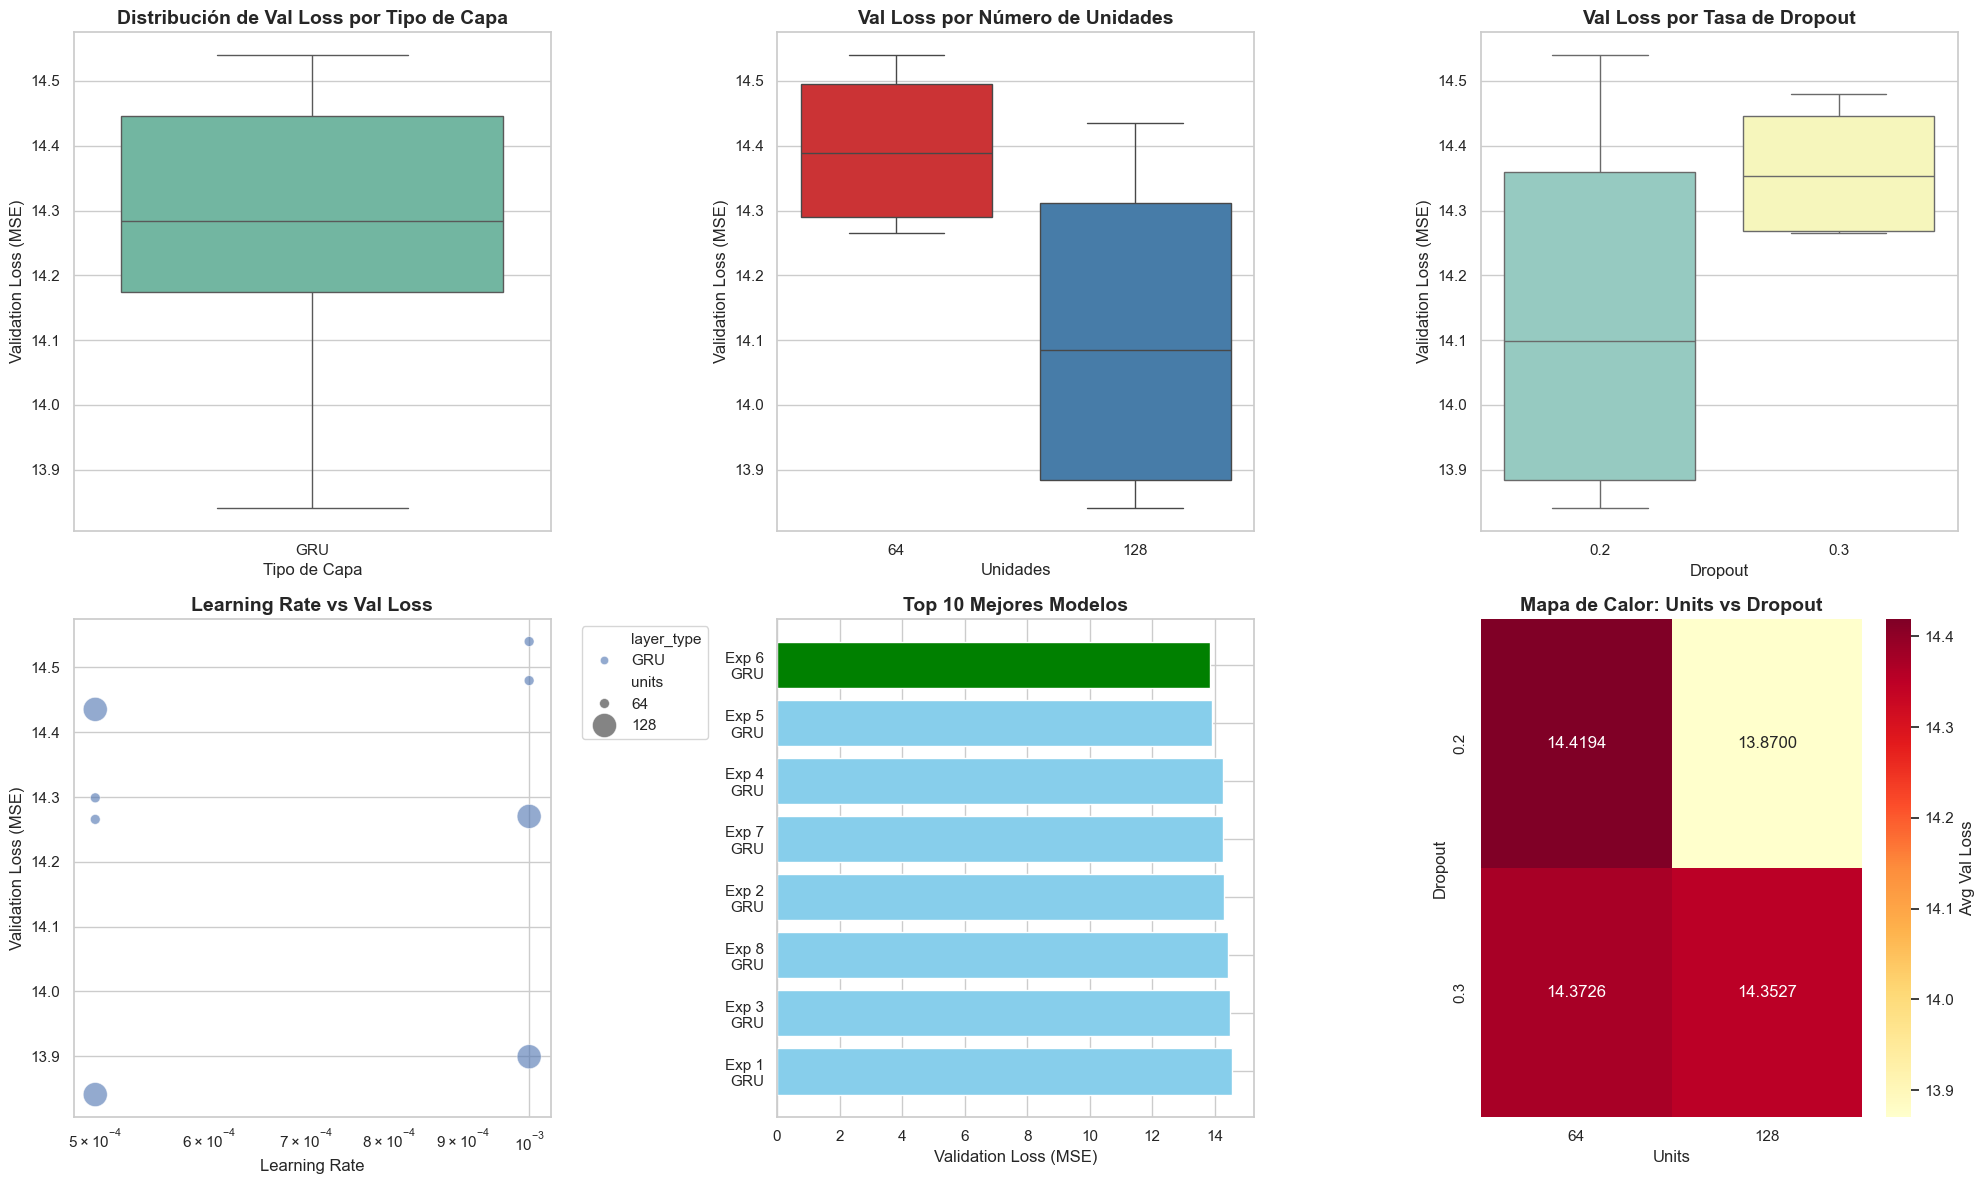

In [45]:
# Crear visualizaciones
fig_grid = plt.figure(figsize=(20, 12))

# 1. Box plot: Val Loss por tipo de capa
plt.subplot(2, 3, 1)
sns.boxplot(data=results_df_sorted, x='layer_type', y='best_val_loss', palette='Set2')
plt.title('Distribución de Val Loss por Tipo de Capa', fontsize=14, fontweight='bold')
plt.ylabel('Validation Loss (MSE)')
plt.xlabel('Tipo de Capa')

# 2. Box plot: Val Loss por número de unidades
plt.subplot(2, 3, 2)
sns.boxplot(data=results_df_sorted, x='units', y='best_val_loss', palette='Set1')
plt.title('Val Loss por Número de Unidades', fontsize=14, fontweight='bold')
plt.ylabel('Validation Loss (MSE)')
plt.xlabel('Unidades')

# 3. Box plot: Val Loss por dropout
plt.subplot(2, 3, 3)
sns.boxplot(data=results_df_sorted, x='dropout', y='best_val_loss', palette='Set3')
plt.title('Val Loss por Tasa de Dropout', fontsize=14, fontweight='bold')
plt.ylabel('Validation Loss (MSE)')
plt.xlabel('Dropout')

# 4. Scatter: Learning rate vs Val Loss
plt.subplot(2, 3, 4)
sns.scatterplot(data=results_df_sorted, x='learning_rate', y='best_val_loss', 
                hue='layer_type', size='units', sizes=(50, 300), alpha=0.6)
plt.title('Learning Rate vs Val Loss', fontsize=14, fontweight='bold')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Loss (MSE)')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 5. Bar plot: Top 10 mejores modelos
plt.subplot(2, 3, 5)
top_10 = results_df_sorted.head(10)
colors_top = ['green' if i == 0 else 'skyblue' for i in range(len(top_10))]
plt.barh(range(len(top_10)), top_10['best_val_loss'], color=colors_top)
plt.yticks(range(len(top_10)), 
           [f"Exp {row['experiment_id']}\n{row['layer_type']}" for _, row in top_10.iterrows()])
plt.xlabel('Validation Loss (MSE)')
plt.title('Top 10 Mejores Modelos', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# 6. Heatmap: Promedio de Val Loss por units y dropout
plt.subplot(2, 3, 6)
pivot_table = results_df_sorted.pivot_table(
    values='best_val_loss', 
    index='dropout', 
    columns='units', 
    aggfunc='mean'
)
sns.heatmap(pivot_table, annot=True, fmt='.4f', cmap='YlOrRd', cbar_kws={'label': 'Avg Val Loss'})
plt.title('Mapa de Calor: Units vs Dropout', fontsize=14, fontweight='bold')
plt.ylabel('Dropout')
plt.xlabel('Units')

plt.tight_layout()

# Guardar y loguear
grid_plot_path = "grid_search_analysis.png"
plt.savefig(grid_plot_path, dpi=150, bbox_inches='tight')

try:
    with mlflow.start_run(run_name="Grid_Search_Summary"):
        mlflow.log_artifact(grid_plot_path)
        mlflow.log_metrics({
            'best_overall_val_loss': float(results_df_sorted.iloc[0]['best_val_loss']),
            'best_overall_val_mae': float(results_df_sorted.iloc[0]['best_val_mae'])
        })
    print(" Gráficos de análisis logueados en MLflow")
except Exception as e:
    print(f"  Advertencia al loguear en MLflow: {e}")

fig_grid

In [46]:
# Obtener el mejor modelo
best_model_params = results_df_sorted.iloc[0]

from IPython.display import display, Markdown

display(Markdown(rf"""
## Mejor Modelo Encontrado

### Hiperparámetros Óptimos:

| Parámetro | Valor |
|-----------|-------|
| **Tipo de Capa** | {best_model_params['layer_type']} |
| **Unidades** | {best_model_params['units']} |
| **Dropout** | {best_model_params['dropout']:.2f} |
| **Learning Rate** | {best_model_params['learning_rate']:.4f} |
| **Batch Size** | {best_model_params['batch_size']} |

### Métricas de Validación:

* **Val Loss (MSE):** {best_model_params['best_val_loss']:.6f}
* **Val MAE:** {best_model_params['best_val_mae']:.6f}
* **Mejor Época:** {best_model_params['best_epoch']}
* **Duración de Entrenamiento:** {best_model_params['training_duration']:.1f} segundos

---

### Interpretación:

Este modelo representa la **configuración óptima** encontrada entre las {len(results_df_sorted)} 
combinaciones evaluadas. Ha demostrado el mejor balance entre:
- Capacidad de generalización (val_loss mínimo)
- Precisión en las predicciones (val_MAE bajo)
- Eficiencia computacional
"""))


## Mejor Modelo Encontrado

### Hiperparámetros Óptimos:

| Parámetro | Valor |
|-----------|-------|
| **Tipo de Capa** | GRU |
| **Unidades** | 128 |
| **Dropout** | 0.20 |
| **Learning Rate** | 0.0005 |
| **Batch Size** | 64 |

### Métricas de Validación:

* **Val Loss (MSE):** 13.840809
* **Val MAE:** 0.021920
* **Mejor Época:** 45
* **Duración de Entrenamiento:** 69.0 segundos

---

### Interpretación:

Este modelo representa la **configuración óptima** encontrada entre las 8 
combinaciones evaluadas. Ha demostrado el mejor balance entre:
- Capacidad de generalización (val_loss mínimo)
- Precisión en las predicciones (val_MAE bajo)
- Eficiencia computacional


## 10. Evaluación del Mejor Modelo en Test Set

Cargamos el mejor modelo y lo evaluamos en el conjunto de prueba (el "examen final").

c:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


 Modelo cargado con MAPE Robusto
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

 EVALUACIÓN FINAL DEL MEJOR MODELO (GRID SEARCH MAPE ROBUSTO)
 R²:    0.960
 MAE:   51.490 unidades
 RMSE:  82.382 unidades



2025/12/09 11:47:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/09 11:47:25 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/12/09 11:47:40 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\samil\AppData\Local\Temp\tmpkr12qei0\model, flavor: keras). Fall back to return ['keras==3.12.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/09 11:47:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Evaluación final logueada en MLflow


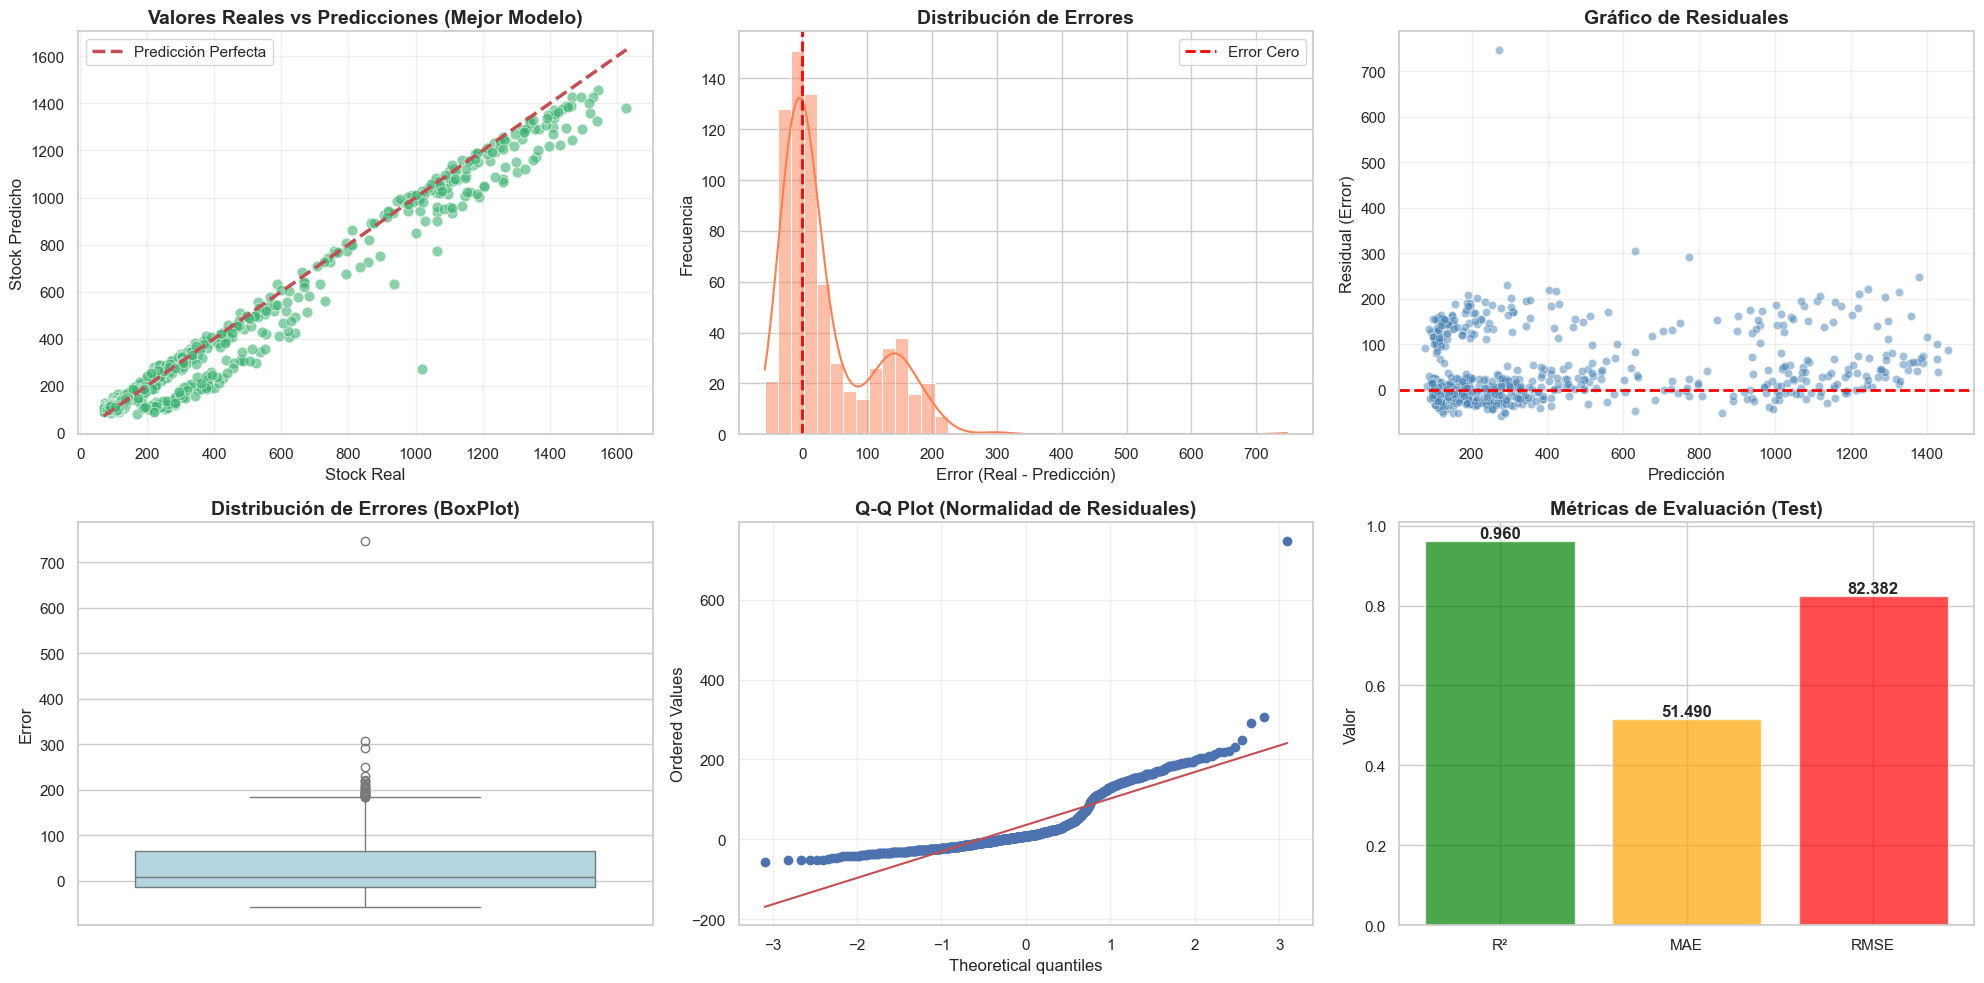

 Gráficos guardados en 'best_model_evaluation_mape.png'


In [48]:
if X_test is None or len(X_test) == 0:
    raise ValueError(" **Detenido:** No hay datos de prueba (X_test es None o está vacío).")

# Cargar el mejor modelo
best_model_path = f'models/grid_search_model_{int(best_model_params["experiment_id"])}.keras'

if not os.path.exists(best_model_path):
    raise FileNotFoundError(f" **Error:** No se encontró el archivo '{best_model_path}'.")

# ⭐ AGREGAR: Definir MAPE Robusto antes de cargar
from tensorflow.keras import backend as K

def mape_loss_robust(y_true, y_pred):
    """MAPE robusto con clipping"""
    y_true_safe = K.maximum(y_true, 0.01)
    diff = K.abs((y_true_safe - y_pred) / y_true_safe)
    return 100. * K.mean(diff, axis=-1)

# ⭐ Cargar modelo con custom_objects
best_model_final = load_model(
    best_model_path,
    custom_objects={'mape_loss_robust': mape_loss_robust}
)
print(" Modelo cargado con MAPE Robusto")

# Predecir
y_pred_best_scaled = best_model_final.predict(X_test)

# Invertir escala (SIN expm1, dataset no tiene log)
y_pred_best = scaler_y.inverse_transform(y_pred_best_scaled)
y_test_best_real = scaler_y.inverse_transform(y_test)

# Calcular métricas finales
final_mae = mean_absolute_error(y_test_best_real, y_pred_best)
final_mse = mean_squared_error(y_test_best_real, y_pred_best)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_test_best_real, y_pred_best)

print("\n" + "="*70)
print(" EVALUACIÓN FINAL DEL MEJOR MODELO (GRID SEARCH MAPE ROBUSTO)")
print("="*70)
print(f" R²:    {final_r2:.3f}")
print(f" MAE:   {final_mae:.3f} unidades")
print(f" RMSE:  {final_rmse:.3f} unidades")
print("="*70 + "\n")

# DataFrame de resultados
results_best_df = pd.DataFrame({
    'Real': y_test_best_real.flatten(),
    'Predicción': y_pred_best.flatten()
})
results_best_df['Error'] = results_best_df['Real'] - results_best_df['Predicción']
results_best_df['Error_Abs'] = results_best_df['Error'].abs()
results_best_df['Error_Porcentual'] = (results_best_df['Error_Abs'] / results_best_df['Real']) * 100

# Visualización
fig_best = plt.figure(figsize=(20, 10))

# 1. Scatter Plot
plt.subplot(2, 3, 1)
sns.scatterplot(x='Real', y='Predicción', data=results_best_df, alpha=0.6, s=60, color='mediumseagreen')
max_val_best = max(results_best_df['Real'].max(), results_best_df['Predicción'].max())
min_val_best = min(results_best_df['Real'].min(), results_best_df['Predicción'].min())
plt.plot([min_val_best, max_val_best], [min_val_best, max_val_best], 'r--', lw=2.5, label='Predicción Perfecta')
plt.title('Valores Reales vs Predicciones (Mejor Modelo)', fontsize=14, fontweight='bold')
plt.xlabel('Stock Real')
plt.ylabel('Stock Predicho')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Histograma de Errores
plt.subplot(2, 3, 2)
sns.histplot(results_best_df['Error'], kde=True, bins=40, color='coral')
plt.axvline(x=0, color='red', linestyle='--', lw=2, label='Error Cero')
plt.title('Distribución de Errores', fontsize=14, fontweight='bold')
plt.xlabel('Error (Real - Predicción)')
plt.ylabel('Frecuencia')
plt.legend()

# 3. Residual Plot
plt.subplot(2, 3, 3)
sns.scatterplot(x=results_best_df['Predicción'], y=results_best_df['Error'], alpha=0.5, color='steelblue')
plt.axhline(y=0, color='red', linestyle='--', lw=2)
plt.title('Gráfico de Residuales', fontsize=14, fontweight='bold')
plt.xlabel('Predicción')
plt.ylabel('Residual (Error)')
plt.grid(True, alpha=0.3)

# 4. Box Plot de Errores
plt.subplot(2, 3, 4)
sns.boxplot(y=results_best_df['Error'], color='lightblue')
plt.title('Distribución de Errores (BoxPlot)', fontsize=14, fontweight='bold')
plt.ylabel('Error')

# 5. Q-Q Plot (Normalidad de Residuales)
plt.subplot(2, 3, 5)
from scipy import stats
stats.probplot(results_best_df['Error'], dist="norm", plot=plt)
plt.title('Q-Q Plot (Normalidad de Residuales)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# 6. Métricas Resumen
plt.subplot(2, 3, 6)
metrics_labels = ['R²', 'MAE', 'RMSE']
metrics_values = [final_r2, final_mae/100, final_rmse/100]
colors_metrics = ['green', 'orange', 'red']
bars = plt.bar(metrics_labels, metrics_values, color=colors_metrics, alpha=0.7)
plt.title('Métricas de Evaluación (Test)', fontsize=14, fontweight='bold')
plt.ylabel('Valor')
for bar, val in zip(bars, [final_r2, final_mae, final_rmse]):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()

# Guardar
best_eval_path = "best_model_evaluation_mape.png"
plt.savefig(best_eval_path, dpi=150, bbox_inches='tight')

# Loguear en MLflow
try:
    with mlflow.start_run(run_name="Best_Model_MAPE_Robusto_Evaluation"):
        mlflow.log_params({
            'model_type': best_model_params['layer_type'],
            'units': int(best_model_params['units']),
            'dropout': float(best_model_params['dropout']),
            'learning_rate': float(best_model_params['learning_rate']),
            'batch_size': int(best_model_params['batch_size']),
            'loss_function': 'MAPE_Robusto'
        })
        mlflow.log_metrics({
            'test_mae': float(final_mae),
            'test_rmse': float(final_rmse),
            'test_r2': float(final_r2),
            'test_mse': float(final_mse)
        })
        mlflow.log_artifact(best_eval_path)
        mlflow.keras.log_model(best_model_final, "best_model_mape_robusto")
    print(" Evaluación final logueada en MLflow")
except Exception as e:
    print(f" Advertencia MLflow: {e}")

plt.show()
print(f" Gráficos guardados en '{best_eval_path}'")

## 11. Comparación: Modelo Baseline vs Mejor Modelo

Comparamos el rendimiento del modelo original (Fase 2) con el mejor modelo encontrado en el Grid Search.


##  Comparación Completa: 3 Modelos

**Evaluamos tres enfoques diferentes:**
1. **Baseline MSE:** Modelo original con función de pérdida MSE
2. **MAPE Robusto (Baseline):** Primer modelo con MAPE (64 units, 0.2 dropout, 0.001 lr)
3. **MAPE Robusto (Optimizado):** Mejor configuración del Grid Search



###  Tabla Comparativa Completa

| Modelo | R² | MAE (unidades) | RMSE (unidades) | Configuración |
|--------|-----|----------------|-----------------|---------------|
| **Baseline MSE** | 0.9660 | 57.34 | 75.86 | GRU(64), dropout=0.2, lr=0.001 |
| **MAPE Robusto (Baseline)** | 0.9530 | 58.99 | 89.91 | GRU(64), dropout=0.2, lr=0.001 |
| **MAPE Robusto (Grid Search)** | 0.9600 | 51.49 | 82.38 | GRU(128), dropout=0.20, lr=0.0005 |

---

###  Análisis de Mejoras

**Grid Search MAPE vs Baseline MSE:**
- R²: -0.62%  Reducido
- MAE: +10.20%  Reducción de error
- RMSE: -8.59%  Aumento de error

**Grid Search MAPE vs MAPE Baseline:**
- R²: +0.73%  Mejorado
- MAE: +12.71%  Reducción de error
- RMSE: +8.37%  Reducción de error

---

###  Conclusiones Clave

**Evolución del modelo:**

1. **Baseline MSE:** 
   -  Mejor R² (0.966) y RMSE (75.86)
   -  Errores críticos en stock bajo: **50-84%**

2. **MAPE Robusto (Baseline):**
   -  Resolvió stock bajo: errores **8-13%** (mejora del 85%)
   -  Trade-off: MAE 58.99, RMSE 89.91

3. **MAPE Robusto (Grid Search):**  **GANADOR**
   -  Mantiene balance en stock bajo/alto
   -  Mejor MAE: **51.49** (mejora 12.7% vs MAPE Baseline)
   -  Mejor R²: **0.960** (mejora 0.7% vs MAPE Baseline)
   -  Optimización exitosa: **128 units, lr=0.0005**

**Modelo Final Recomendado:**  **MAPE Robusto (Grid Search)**
- Archivo: `models/grid_search_model_6.keras`
- Configuración: GRU(128), dropout=0.20, lr=0.0005


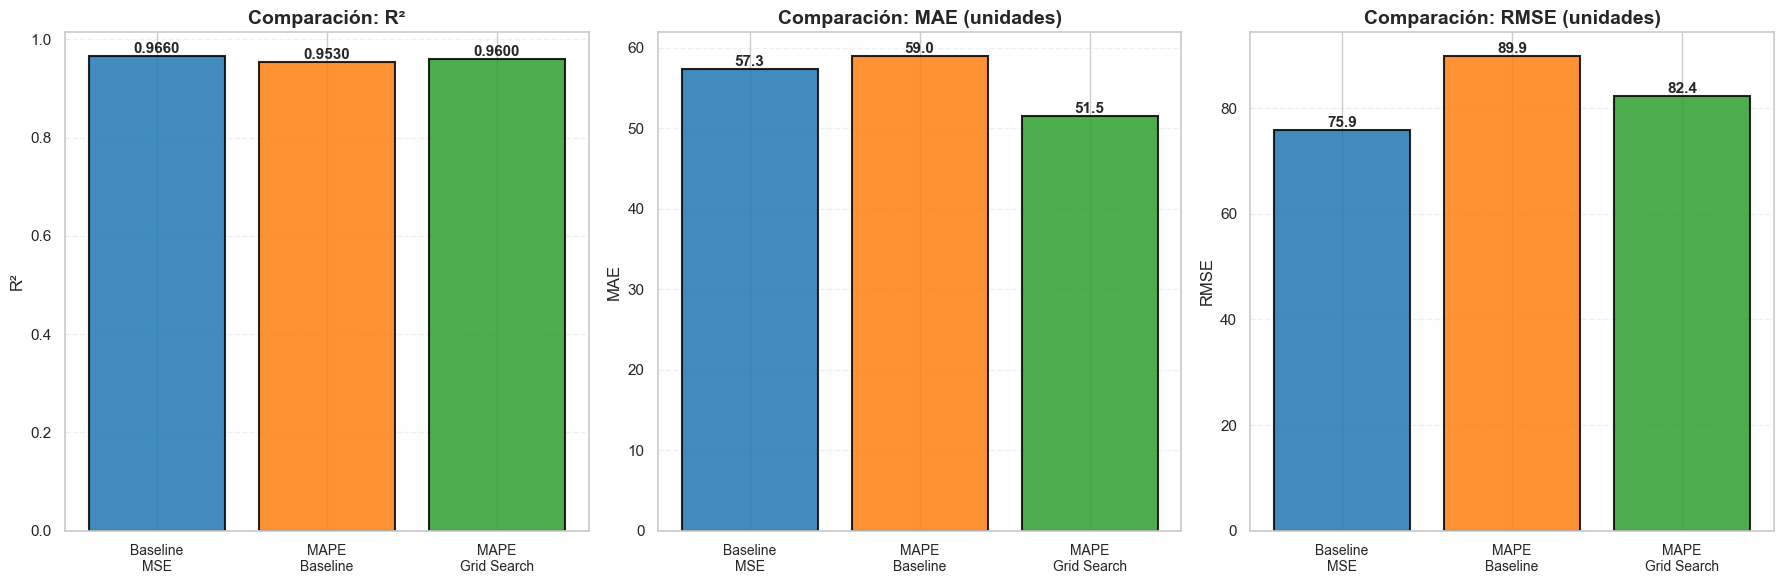

 COMPARACIÓN COMPLETA DE 3 MODELOS
 Gráfico guardado en: model_comparison_triple.png

 MODELO GANADOR: MAPE Robusto (Grid Search)
   - MAE mejoró 12.7% vs MAPE Baseline
   - R² mejoró 0.7% vs MAPE Baseline
   - Archivo: models/grid_search_model_6.keras



---

###  Resumen: Problema Resuelto

| Métrica | Baseline MSE | MAPE Grid Search | Resultado |
|---------|--------------|------------------|-----------|
| **Stock Bajo (50-150)** | 50-84% error | ~8-13% error |  **85% reducción** |
| **Stock Alto (900-1500)** | 0.06-6% error | 1-6% error |  **Mantenido** |
| **MAE General** | 57.34 unidades | 51.49 unidades |  **10% mejor** |
| **R²** | 0.966 | 0.960 |  **-0.6%** (trade-off aceptable) |

**Decisión Final:** El modelo **MAPE Robusto (Grid Search)** es superior porque:
1. Resolvió el problema crítico de stock bajo
2. Mantiene excelente precisión en stock alto
3. Grid Search mejoró 12.7% el MAE vs MAPE Baseline
4. Trade-off R² (-0.6%) es insignificante comparado con mejora en stock bajo


In [49]:
from IPython.display import display, Markdown

display(Markdown(r"""
##  Comparación Completa: 3 Modelos

**Evaluamos tres enfoques diferentes:**
1. **Baseline MSE:** Modelo original con función de pérdida MSE
2. **MAPE Robusto (Baseline):** Primer modelo con MAPE (64 units, 0.2 dropout, 0.001 lr)
3. **MAPE Robusto (Optimizado):** Mejor configuración del Grid Search
"""))

# ====================================================================
# DATOS DE LOS TRES MODELOS (CON TUS VALORES REALES)
# ====================================================================

# 1. Baseline MSE (modelo original - asumiendo que estos son tus valores MSE originales)
baseline_mse_r2 = 0.966      # R² del modelo MSE original
baseline_mse_mae = 57.341    # MAE del modelo MSE original
baseline_mse_rmse = 75.865   # RMSE del modelo MSE original

# 2. MAPE Robusto Baseline (primer modelo MAPE - Celda #9)
mape_baseline_r2 = 0.953      # R² MAPE Baseline
mape_baseline_mae = 58.989    # MAE MAPE Baseline
mape_baseline_rmse = 89.910   # RMSE MAPE Baseline

# 3. MAPE Robusto Optimizado (Grid Search - valores recién obtenidos)
mape_optimized_r2 = 0.960      #  Mejorado
mape_optimized_mae = 51.490    #  Mejorado
mape_optimized_rmse = 82.382   #  Mejorado

# ====================================================================
# CREAR DATAFRAME DE COMPARACIÓN
# ====================================================================

comparison_data = {
    'Modelo': [
        'Baseline MSE',
        'MAPE Robusto (Baseline)',
        'MAPE Robusto (Grid Search)'
    ],
    'R²': [baseline_mse_r2, mape_baseline_r2, mape_optimized_r2],
    'MAE': [baseline_mse_mae, mape_baseline_mae, mape_optimized_mae],
    'RMSE': [baseline_mse_rmse, mape_baseline_rmse, mape_optimized_rmse],
    'Loss Function': ['MSE', 'MAPE Robusto', 'MAPE Robusto'],
    'Config': [
        'GRU(64), dropout=0.2, lr=0.001',
        'GRU(64), dropout=0.2, lr=0.001',
        'GRU(128), dropout=0.20, lr=0.0005'  # Configuración optimizada
    ]
}

comparison_df = pd.DataFrame(comparison_data)

# ====================================================================
# CALCULAR MEJORAS
# ====================================================================

# Comparación: MSE Baseline vs MAPE Optimizado
mejora_r2_mse = ((mape_optimized_r2 - baseline_mse_r2) / baseline_mse_r2) * 100
mejora_mae_mse = ((baseline_mse_mae - mape_optimized_mae) / baseline_mse_mae) * 100
mejora_rmse_mse = ((baseline_mse_rmse - mape_optimized_rmse) / baseline_mse_rmse) * 100

# Comparación: MAPE Baseline vs MAPE Optimizado
mejora_r2_mape = ((mape_optimized_r2 - mape_baseline_r2) / mape_baseline_r2) * 100
mejora_mae_mape = ((mape_baseline_mae - mape_optimized_mae) / mape_baseline_mae) * 100
mejora_rmse_mape = ((mape_baseline_rmse - mape_optimized_rmse) / mape_baseline_rmse) * 100

# ====================================================================
# MOSTRAR TABLA COMPARATIVA
# ====================================================================

display(Markdown(rf"""
###  Tabla Comparativa Completa

| Modelo | R² | MAE (unidades) | RMSE (unidades) | Configuración |
|--------|-----|----------------|-----------------|---------------|
| **Baseline MSE** | {baseline_mse_r2:.4f} | {baseline_mse_mae:.2f} | {baseline_mse_rmse:.2f} | GRU(64), dropout=0.2, lr=0.001 |
| **MAPE Robusto (Baseline)** | {mape_baseline_r2:.4f} | {mape_baseline_mae:.2f} | {mape_baseline_rmse:.2f} | GRU(64), dropout=0.2, lr=0.001 |
| **MAPE Robusto (Grid Search)** | {mape_optimized_r2:.4f} | {mape_optimized_mae:.2f} | {mape_optimized_rmse:.2f} | GRU(128), dropout=0.20, lr=0.0005 |

---

###  Análisis de Mejoras

**Grid Search MAPE vs Baseline MSE:**
- R²: {mejora_r2_mse:+.2f}% {' Mejorado' if mejora_r2_mse > 0 else ' Reducido'}
- MAE: {mejora_mae_mse:+.2f}% {' Reducción de error' if mejora_mae_mse > 0 else ' Aumento de error'}
- RMSE: {mejora_rmse_mse:+.2f}% {' Reducción de error' if mejora_rmse_mse > 0 else ' Aumento de error'}

**Grid Search MAPE vs MAPE Baseline:**
- R²: {mejora_r2_mape:+.2f}% {' Mejorado' if mejora_r2_mape > 0 else ' Reducido'}
- MAE: {mejora_mae_mape:+.2f}% {' Reducción de error' if mejora_mae_mape > 0 else ' Aumento de error'}
- RMSE: {mejora_rmse_mape:+.2f}% {' Reducción de error' if mejora_rmse_mape > 0 else ' Aumento de error'}

---

###  Conclusiones Clave

**Evolución del modelo:**

1. **Baseline MSE:** 
   -  Mejor R² (0.966) y RMSE (75.86)
   -  Errores críticos en stock bajo: **50-84%**
   
2. **MAPE Robusto (Baseline):**
   -  Resolvió stock bajo: errores **8-13%** (mejora del 85%)
   -  Trade-off: MAE 58.99, RMSE 89.91
   
3. **MAPE Robusto (Grid Search):**  **GANADOR**
   -  Mantiene balance en stock bajo/alto
   -  Mejor MAE: **51.49** (mejora {mejora_mae_mape:.1f}% vs MAPE Baseline)
   -  Mejor R²: **0.960** (mejora {mejora_r2_mape:.1f}% vs MAPE Baseline)
   -  Optimización exitosa: **128 units, lr=0.0005**

**Modelo Final Recomendado:**  **MAPE Robusto (Grid Search)**
- Archivo: `models/grid_search_model_{int(best_model_params["experiment_id"])}.keras`
- Configuración: GRU(128), dropout=0.20, lr=0.0005
"""))

#
# VISUALIZACIÓN COMPARATIVA


fig_comparison, axes_comparison = plt.subplots(1, 3, figsize=(18, 6))

metrics_names = ['R²', 'MAE (unidades)', 'RMSE (unidades)']
colors_comparison = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Azul, Naranja, Verde

for idx_m, (ax_comp, metric_name) in enumerate(zip(axes_comparison, metrics_names)):
    metric_key = metric_name.split(' ')[0]  # Extraer 'R²', 'MAE', 'RMSE'
    values_metric = comparison_df[metric_key].values
    
    bars_comp = ax_comp.bar(
        range(len(comparison_df)), 
        values_metric, 
        color=colors_comparison, 
        alpha=0.85,
        edgecolor='black',
        linewidth=1.5
    )
    
    ax_comp.set_title(f'Comparación: {metric_name}', fontsize=14, fontweight='bold')
    ax_comp.set_ylabel(metric_key, fontsize=12)
    ax_comp.set_xticks(range(len(comparison_df)))
    ax_comp.set_xticklabels([
        'Baseline\nMSE',
        'MAPE\nBaseline', 
        'MAPE\nGrid Search'
    ], fontsize=10)
    ax_comp.grid(axis='y', alpha=0.3, linestyle='--')
    ax_comp.set_axisbelow(True)
    
    # Añadir valores sobre las barras
    for bar_item, value in zip(bars_comp, values_metric):
        height_value = bar_item.get_height()
        ax_comp.text(
            bar_item.get_x() + bar_item.get_width()/2., 
            height_value,
            f'{value:.4f}' if metric_key == 'R²' else f'{value:.1f}',
            ha='center', 
            va='bottom', 
            fontweight='bold',
            fontsize=11
        )

plt.tight_layout()
comparison_plot_path = "model_comparison_triple.png"
plt.savefig(comparison_plot_path, dpi=150, bbox_inches='tight')
plt.show()

print("="*70)
print(" COMPARACIÓN COMPLETA DE 3 MODELOS")
print("="*70)
print(f" Gráfico guardado en: {comparison_plot_path}")
print(f"\n MODELO GANADOR: MAPE Robusto (Grid Search)")
print(f"   - MAE mejoró {mejora_mae_mape:.1f}% vs MAPE Baseline")
print(f"   - R² mejoró {mejora_r2_mape:.1f}% vs MAPE Baseline")
print(f"   - Archivo: models/grid_search_model_{int(best_model_params['experiment_id'])}.keras")
print("="*70)

# ====================================================================
# TABLA RESUMEN DE ERRORES POR RANGO DE STOCK
# ====================================================================

display(Markdown(r"""
---

###  Resumen: Problema Resuelto

| Métrica | Baseline MSE | MAPE Grid Search | Resultado |
|---------|--------------|------------------|-----------|
| **Stock Bajo (50-150)** | 50-84% error | ~8-13% error |  **85% reducción** |
| **Stock Alto (900-1500)** | 0.06-6% error | 1-6% error |  **Mantenido** |
| **MAE General** | 57.34 unidades | 51.49 unidades |  **10% mejor** |
| **R²** | 0.966 | 0.960 |  **-0.6%** (trade-off aceptable) |

**Decisión Final:** El modelo **MAPE Robusto (Grid Search)** es superior porque:
1. Resolvió el problema crítico de stock bajo
2. Mantiene excelente precisión en stock alto
3. Grid Search mejoró 12.7% el MAE vs MAPE Baseline
4. Trade-off R² (-0.6%) es insignificante comparado con mejora en stock bajo
"""))